# EU Parliament Debates Knowledge Graph Analysis

## 1. Setup & Configuration


### 1.1 Install Dependencies


In [38]:
# Install required packages
!pip install -q datasets pandas google-generativeai groq networkx matplotlib seaborn openai pydantic tqdm python-louvain scikit-learn transformers
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
!pip install accelerate
!pip install bitsandbytes
!pip install accelerate transformers


# imports
import os
import json
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import community as community_louvain
from collections import Counter
from datetime import datetime
from typing import List, Optional, Dict
from pydantic import BaseModel, Field
from openai import OpenAI
from datasets import load_dataset
from tqdm.auto import tqdm
import warnings

warnings.filterwarnings('ignore')

# Set style for visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All dependencies loaded successfully!")

os.makedirs('outputs', exist_ok=True)
os.makedirs('visualizations', exist_ok=True)

print("✓ Created outputs/ and visualizations/ directories")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://download.pytorch.org/whl/cu126



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ All dependencies loaded successfully!
✓ Created outputs/ and visualizations/ directories



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### 1.2 Configuration Parameters


In [39]:
# Configuration
SAMPLE_SIZE = 500  
START_YEAR = 2020
END_YEAR = 2023
MIN_TEXT_LENGTH = 100
BATCH_SIZE = 4
MODEL_PATH = "./Llama-3.1-8B-Instruct"
SEED = 42

print("✅ Configuration loaded!")
print(f"   Sample size: {SAMPLE_SIZE}")
print(f"   Years: {START_YEAR}-{END_YEAR}")
print(f"   Batch size: {BATCH_SIZE}")

✅ Configuration loaded!
   Sample size: 500
   Years: 2020-2023
   Batch size: 4


## 2. Model Loading

### 2.1 Load Llama 3.1 8B Instruct Model


In [40]:
# Configure local Llama 3.1 8B Instruct model
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

MODEL_PATH = "./Llama-3.1-8B-Instruct"

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)


tokenizer.padding_side = "left"


if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


print("Loading model in 4-bit...")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH,
    quantization_config=bnb_config,
    device_map="auto",
)

print("Loaded!")
print("Model device:", next(model.parameters()).device)



Device: cuda
Loading tokenizer...
Loading model in 4-bit...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded!
Model device: cuda:0


## 3. Data Loading & Preprocessing




### 3.1 Load Dataset



*


In [ ]:
# Constants
YEAR_FILTER = 2021

# Load and filter dataset
print("Loading EU Debates dataset...")
debates = load_dataset("RJuro/eu_debates", split="train")

# Filter by year
debates_filtered = debates.filter(lambda x: x['date'].year == YEAR_FILTER)

# Shuffle and sample
debates_sample = debates_filtered.shuffle(seed=SEED).select(range(min(SAMPLE_SIZE, len(debates_filtered))))

# Convert to pandas
df_sample = debates_sample.to_pandas()

print(f"Dataset loaded: {len(df_sample)} speeches from {YEAR_FILTER}")
print(f"Columns: {df_sample.columns.tolist()}")



Loading EU Debates dataset...
Dataset loaded: 500 speeches from 2021
Columns: ['speaker_name', 'speaker_role', 'speaker_party', 'intervention_language', 'original_language', 'date', 'year', 'debate_title', 'text', 'translated_text']


In [42]:
# Load the EU debates dataset
print("Loading EU Debates dataset...")
dataset = load_dataset("RJuro/eu_debates", split="train")
print(f"Total speeches in dataset: {len(dataset):,}")

# Convert to pandas for easier manipulation
df_full = pd.DataFrame(dataset)

# Parse date and filter for START_YEAR-END_YEAR
df_full['date'] = pd.to_datetime(df_full['date'], errors='coerce')
df_full['year'] = df_full['date'].dt.year

# Filter for target years
df_filtered = df_full[(df_full['year'] >= START_YEAR) & (df_full['year'] <= END_YEAR)].copy()
print(f"Speeches from {START_YEAR}-{END_YEAR}: {len(df_filtered):,}")

# Additional filtering: remove very short speeches (< MIN_TEXT_LENGTH characters)
df_filtered['text_length'] = df_filtered['text'].str.len()
df_filtered = df_filtered[df_filtered['text_length'] >= MIN_TEXT_LENGTH].copy()
print(f"After removing short speeches: {len(df_filtered):,}")

print(f"\nBefore party filtering: {len(df_filtered):,}")
df_filtered = df_filtered[ (df_filtered['speaker_party'].notna()) & (df_filtered['speaker_party'] != '') &(df_filtered['speaker_party'] != 'N/A')].copy()
print(f"After party filtering: {len(df_filtered):,}")
total_year_range = len(df_full[(df_full['year'] >= START_YEAR) & (df_full['year'] <= END_YEAR)])
print(f"Speeches with party metadata: {len(df_filtered)/total_year_range*100:.1f}%")

# Sample SAMPLE_SIZE speeches with stratification by year
df_sample = df_filtered.groupby('year', group_keys=False).apply(lambda x: x.sample(n=min(len(x), SAMPLE_SIZE // 4), random_state=SEED)).reset_index(drop=True)

print(f"\n✅ Final sample: {len(df_sample)} speeches")
print(f"Year distribution:\n{df_sample['year'].value_counts().sort_index()}")
print(f"\nParty distribution in sample:")
print(df_sample['speaker_party'].value_counts().head(10))

# Display sample
print("\nSample speeches:")
print(df_sample[['speaker_name', 'speaker_party', 'date', 'text']].head(3))

Loading EU Debates dataset...
Total speeches in dataset: 106,598
Speeches from 2020-2023: 46,737
After removing short speeches: 45,476

Before party filtering: 45,476
After party filtering: 35,640
Speeches with party metadata: 76.3%

✅ Final sample: 500 speeches
Year distribution:
year
2020    125
2021    125
2022    125
2023    125
Name: count, dtype: int64

Party distribution in sample:
speaker_party
S&D           122
PPE           107
ALDE           69
ID             52
ECR            47
Greens/EFA     42
GUE/NGL        34
NI             27
Name: count, dtype: int64

Sample speeches:
                   speaker_name speaker_party       date  \
0                  Tiemo Wölken           S&D 2020-12-15   
1          Vilija Blinkevičiūtė           S&D 2020-07-23   
2  Joachim Stanisław Brudziński           ECR 2020-04-16   

                                                text  
0   – Sehr geehrte Frau Präsidentin Hautala, sehr...  
1  raštu. – Iš tiesų valstybėms narėms pavyko ras...  


### 3.2 Filter by Party


In [43]:
# Filter out speeches without party metadata (already in dataset!)
print(f"Before party filtering: {len(df_sample):,}")

# The dataset already has 'speaker_party' column - just filter nulls
df_sample = df_sample[df_sample['speaker_party'].notna()].copy()
df_sample = df_sample[df_sample['speaker_party'] != ''].copy()

print(f"After party filtering: {len(df_sample):,}")
print(f"Speeches with party metadata: {len(df_sample)/len(df_filtered)*100:.1f}%")

print("\nParty distribution in sample:")
print(df_sample['speaker_party'].value_counts())


Before party filtering: 500
After party filtering: 500
Speeches with party metadata: 1.4%

Party distribution in sample:
speaker_party
S&D           122
PPE           107
ALDE           69
ID             52
ECR            47
Greens/EFA     42
GUE/NGL        34
NI             27
Name: count, dtype: int64


### 3.3 Map Parties to Political Orientation


In [44]:
# EU Parliament Group to Political Orientation Mapping (Hardcoded)
# Based on standard EU Parliament political groups

# Define the mapping dictionary
EU_PARTY_ORIENTATION = {
    # Left
    'GUE/NGL': 'left',          # European United Left–Nordic Green Left
    'The Left': 'left',
    'LEFT': 'left',
    
    # Center-Left / Greens
    'Greens/EFA': 'left',       # Greens/European Free Alliance
    'Verts/ALE': 'left',
    'Greens': 'left',
    
    # Center-Left (Social Democrats)
    'S&D': 'center',            # Progressive Alliance of Socialists and Democrats
    'S&amp;D': 'center',
    'PES': 'center',
    'PSE': 'center',
    'Socialists': 'center',
    
    # Center (Liberals)
    'Renew Europe': 'center',   # Renew Europe (formerly ALDE)
    'ALDE': 'center',           # Alliance of Liberals and Democrats for Europe
    'Renew': 'center',
    
    # Center-Right
    'EPP': 'right',             # European People's Party
    'PPE': 'right',
    
    # Right (Conservatives)
    'ECR': 'right',             # European Conservatives and Reformists
    
    # Far-Right
    'ID': 'right',              # Identity and Democracy
    'ENF': 'right',             # Europe of Nations and Freedom (predecessor to ID)
    'EFD': 'right',             # Europe of Freedom and Direct Democracy
    
    # Non-attached
    'NI': 'unknown',            # Non-Inscrits (non-attached members)
    'Non-attached': 'unknown',
}

def map_party_to_orientation(party: str) -> str:
    """
    Map EU Parliament party group to political orientation.
    
    Args:
        party: EU Parliament party group name
        
    Returns:
        'left', 'center', 'right', or 'unknown'
    """
    if pd.isna(party) or party == '':
        return 'unknown'
    
    # Direct lookup
    orientation = EU_PARTY_ORIENTATION.get(party, 'unknown')
    
    return orientation

# Apply mapping to df_sample
df_sample['political_orientation'] = df_sample['speaker_party'].apply(map_party_to_orientation)

print("Political orientation distribution:")
print(df_sample['political_orientation'].value_counts())

print("\nParty → Orientation mapping:")
party_orientation = df_sample.groupby('speaker_party')['political_orientation'].first().sort_index()
for party, orientation in party_orientation.items():
    print(f"  {party:30s} → {orientation}")


Political orientation distribution:
political_orientation
right      206
center     191
left        76
unknown     27
Name: count, dtype: int64

Party → Orientation mapping:
  ALDE                           → center
  ECR                            → right
  GUE/NGL                        → left
  Greens/EFA                     → left
  ID                             → right
  NI                             → unknown
  PPE                            → right
  S&D                            → center


## 4. Extraction Schema
### 4.1 Define Pydantic Models


In [45]:
# Define Pydantic models for structured extraction

class TopicMention(BaseModel):
    """A topic mentioned in the speech."""
    topic: str = Field(description="The main topic or issue discussed (e.g., 'Climate Change', 'Migration', 'Economic Policy')")
    confidence: float = Field(description="Confidence score between 0 and 1 indicating how central this topic is to the speech", ge=0.0, le=1.0)

class Entity(BaseModel):
    """An entity mentioned in the speech."""
    name: str = Field(description="Name of the person, organization, or place")
    entity_type: str = Field(description="Type of entity: 'person', 'organization', 'location', or 'other'")

class SpeechExtraction(BaseModel):
    """Structured information extracted from an EU Parliament speech."""
    speaker_name: str = Field(description="Full name of the speaker")
    topics: List[TopicMention] = Field(description="List of main topics discussed, ordered by importance")
    entities: List[Entity] = Field(default=[], description="Key entities mentioned in the speech")
    sentiment: str = Field(description="Overall sentiment: 'positive', 'negative', 'neutral', or 'mixed'")
    summary: str = Field(description="One-sentence summary of the speech")

print("✅ Pydantic schema defined successfully!")
print("\nSchema structure:")
print(json.dumps(SpeechExtraction.model_json_schema(), indent=2)[:500] + "...")


✅ Pydantic schema defined successfully!

Schema structure:
{
  "$defs": {
    "Entity": {
      "description": "An entity mentioned in the speech.",
      "properties": {
        "name": {
          "description": "Name of the person, organization, or place",
          "title": "Name",
          "type": "string"
        },
        "entity_type": {
          "description": "Type of entity: 'person', 'organization', 'location', or 'other'",
          "title": "Entity Type",
          "type": "string"
        }
      },
      "required": [
        "name",
...


## 5. LLM Extraction Functions
### 5.1 Single Speech Extraction


In [46]:
def extract_speech_info(text: str, speaker_name: str) -> Optional[SpeechExtraction]:
    """
    Extract structured information from a speech using local Llama model.

    Args:
        text: The speech text
        speaker_name: Name of the speaker
        speaker_name: Party of the speaker

    Returns:
        SpeechExtraction object or None if extraction fails
    """

    system_prompt = """You are an expert political analyst specializing in European Parliament debates.
Your task is to extract structured information from speeches with high accuracy.
Focus on identifying the main topics, key entities, and overall sentiment.
Be precise and conservative - only extract information that is clearly present in the text.
You MUST return a valid JSON object with ALL required fields."""

    user_prompt = f"""Analyze the following EU Parliament speech and extract structured information.

Speaker: {speaker_name}
Party: {speaker_name}

Speech text:
---
{text[:2000]}
---

You MUST return a JSON object with this EXACT structure:

{{
  "speaker_name": "{speaker_name}",
  "party": "party name or null if unknown",
  "country": "country name or null if unknown",
  "topics": [
    {{"topic": "topic name", "confidence": 0.9}},
    {{"topic": "another topic", "confidence": 0.7}}
  ],
  "entities": [
    {{"name": "entity name", "entity_type": "person|organization|location|other"}}
  ],
  "sentiment": "positive|negative|neutral|mixed",
  "political_orientation": "left|center|right|unknown",
  "summary": "One sentence summary of the speech"
}}

Requirements:
- speaker_name: MUST be "{speaker_name}" (exactly as provided)
- party: MUST be "{speaker_name}" (from dataset metadata)
- country: String or null
- topics: List of 2–5 topics with confidence scores (0.0 to 1.0)
- entities: List of key entities mentioned (can be empty list [])
- sentiment: One of: "positive", "negative", "neutral", "mixed"
- political_orientation: One of: "left", "center", "right", "unknown"
  (Infer from party affiliation and speech content. Left = progressive/socialist, Right = conservative)
- summary: One clear sentence summarizing the speech

Respond with ONLY the JSON object. No explanations, no markdown.
"""

    # Format prompt for Llama
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    try:
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=4096)
        if device == "cuda":
            inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=1000,
                temperature=0.3,
                do_sample=True,
                top_p=0.9,
                pad_token_id=tokenizer.eos_token_id
            )

        response = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)

        json_start = response.find('{')
        json_end = response.rfind('}') + 1
        if json_start != -1 and json_end > json_start:
            json_str = response[json_start:json_end]
        else:
            json_str = response

        data = json.loads(json_str)

        # Fallbacks
        data['speaker_name'] = data.get('speaker_name', speaker_name)
        data.setdefault('topics', [])
        data.setdefault('entities', [])
        data.setdefault('sentiment', 'neutral')
        data.setdefault('summary', 'No summary available')

        extraction = SpeechExtraction(**data)
        return extraction

    except (json.JSONDecodeError, ValidationError) as e:
        print(f"❌ Extraction error: {str(e)[:100]}")
        return None
    except Exception as e:
        print(f"❌ Unexpected error: {str(e)[:100]}")
        return None


print("✅ Local extraction function defined!")


✅ Local extraction function defined!


### 5.2 Batched Extraction Function


In [47]:
from typing import List, Optional

def extract_speech_info_batched(
    texts: List[str],
    speaker_names: List[str],
    speaker_parties: List[Optional[str]],  # ✅ NEW
    batch_size: int = 4
) -> List[Optional[SpeechExtraction]]:
    """
    Batched structured extraction with party context.
    """
    system_prompt = (
        "You are an expert political analyst specializing in European Parliament debates.\n"
        "Your task is to extract structured information from speeches with high accuracy.\n"
        "Focus on identifying the main topics, key entities, and overall sentiment.\n"
        "Be precise and conservative - only extract information that is clearly present in the text.\n"
        "You MUST return a valid JSON object with ALL required fields."
    )

    all_results: List[Optional[SpeechExtraction]] = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_speakers = speaker_names[i:i + batch_size]
        batch_parties = speaker_parties[i:i + batch_size]  # ✅ NEW

        batch_prompts: List[str] = []
        for text, speaker, party in zip(batch_texts, batch_speakers, batch_parties):
            party_str = party if (party is not None and str(party).strip()) else "null"  # ✅ robust fallback

            user_prompt = f"""
Analyze the following EU Parliament speech and extract structured information.

Speaker: {speaker}
Party: {party_str}

Speech text:
---
{text[:2000]}
---

You MUST return a JSON object with this EXACT structure:
{{
  "speaker_name": "{speaker}",
  "party": "{party_str}",
  "country": null,
  "topics": [
    {{"topic": "topic name", "confidence": 0.9}},
    {{"topic": "another topic", "confidence": 0.7}}
  ],
  "entities": [
    {{"name": "entity name", "entity_type": "person|organization|location|other"}}
  ],
  "sentiment": "positive|negative|neutral|mixed",
  "political_orientation": "left|center|right|unknown",
  "summary": "One sentence summary of the speech"
}}

Requirements:
- speaker_name: MUST be "{speaker}" (exactly as provided)
- party: String or null
- country: String or null
- topics: List of 2-5 topics with confidence scores (0.0 to 1.0)
- entities: List of key entities mentioned (can be empty list [])
- sentiment: MUST be one of: "positive", "negative", "neutral", "mixed"
- political_orientation: MUST be one of: "left", "center", "right", "unknown"
- summary: One clear sentence summarizing the speech

Return ONLY the JSON object, no additional text.
""".strip()

            messages = [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ]

            prompt = tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True
            )
            batch_prompts.append(prompt)

        try:
            inputs = tokenizer(
                batch_prompts,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=4096
            )
            if device == "cuda":
                inputs = {k: v.to(device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=1000,
                    temperature=0.3,
                    do_sample=True,
                    top_p=0.9,
                    pad_token_id=tokenizer.eos_token_id
                )

            for j, output in enumerate(outputs):
                try:
                    response = tokenizer.decode(
                        output[inputs['input_ids'].shape[1]:],
                        skip_special_tokens=True
                    )

                    json_start = response.find('{')
                    json_end = response.rfind('}') + 1
                    json_str = response[json_start:json_end] if json_start != -1 else response

                    data = json.loads(json_str)

                    # Normalize required fields + party fallback
                    data['speaker_name'] = data.get('speaker_name', batch_speakers[j])
                    data['party'] = data.get('party', batch_parties[j])  # ✅ FIX
                    data.setdefault('topics', [])
                    data.setdefault('entities', [])
                    data.setdefault('sentiment', 'neutral')
                    data.setdefault('political_orientation', 'unknown')
                    data.setdefault('summary', 'No summary available')

                    extraction = SpeechExtraction(**data)  # extra keys are ignored by pydantic
                    all_results.append(extraction)

                except Exception as e:
                    print(f"❌ Error parsing response {i + j}: {e}")
                    all_results.append(None)

        except Exception as e:
            print(f"❌ Error processing batch starting at {i}: {e}")
            all_results.extend([None] * len(batch_texts))

    return all_results

print("✅ Batched extraction function updated to accept parties.")

# ---------- FIX call site in Section 6 ----------
batch_size = BATCH_SIZE
extractions: List[dict] = []
failed_indices: List[int] = []

print(f"🔄 Starting batched extraction for {len(df_sample)} speeches...\n")

for i in tqdm(range(0, len(df_sample), batch_size), desc="Processing batches"):
    batch_df = df_sample.iloc[i:i+batch_size]

    batch_results = extract_speech_info_batched(
        texts=batch_df['text'].tolist(),
        speaker_names=batch_df['speaker_name'].tolist(),
        speaker_parties=batch_df['speaker_party'].tolist(),  # ✅ NEW
        batch_size=batch_size
    )

    for j, result in enumerate(batch_results):
        if result:
            row = batch_df.iloc[j]
            result_dict = result.model_dump()
            result_dict['source_id'] = row.get('id', i + j)
            result_dict['date'] = row['date']
            result_dict['year'] = row['year']
            result_dict['original_text'] = row['text'][:500]
            # Preserve dataset metadata
            result_dict['party'] = row['speaker_party']
            result_dict['country'] = row.get('speaker_country', None)
            result_dict['political_orientation'] = row['political_orientation']
            extractions.append(result_dict)
        else:
            failed_indices.append(i + j)

df_extractions = pd.DataFrame(extractions)
os.makedirs("data", exist_ok=True)
df_extractions.to_json("data/extractions_raw.json", orient="records", indent=2)

print(f"\n✅ Extraction complete!")
print(f"Successfully extracted: {len(extractions)} speeches")
print(f"Failed: {len(failed_indices)} speeches")
print(f"Success rate: {len(extractions) / len(df_sample) * 100:.1f}%")
print(f"\n✅ Extraction complete with party metadata from dataset")

✅ Batched extraction function updated to accept parties.
🔄 Starting batched extraction for 500 speeches...



Processing batches:   0%|          | 0/125 [00:00<?, ?it/s]


✅ Extraction complete!
Successfully extracted: 500 speeches
Failed: 0 speeches
Success rate: 100.0%

✅ Extraction complete with party metadata from dataset


## 7. Quality Assessment


### 7.1 Manual Quality Assessment & Limitations


In [ ]:
print("QUALITY ASSESSMENT - Manual Inspection of LLM Extractions")

# Sample 15 random extractions for manual inspection
np.random.seed(42)
sample_indices = np.random.choice(len(df_extractions), size=min(15, len(df_extractions)), replace=False)

print(f"\nManually inspecting {len(sample_indices)} random extractions")

correct_topics = 0
correct_entities = 0
correct_sentiment = 0
total_samples = len(sample_indices)

for idx in sample_indices:
    row = df_extractions.iloc[idx]
    
    print(f"Sample {idx + 1}")
    print(f"Speaker: {row['speaker_name']}")
    print(f"Party: {row['party']} ({row['political_orientation']})")
    print(f"\nOriginal Text (first 300 chars):")
    print(f"{df_sample.iloc[idx]['text'][:300]}...")
    print(f"EXTRACTED DATA:")
    print(f"Topics: {row['topics']}")
    print(f"Entities: {row['entities']}")
    print(f"Sentiment: {row['sentiment']}")
    print(f"Summary: {row['summary']}")
    
    
    # Heuristic quality checks
    has_topics = len(row['topics']) > 0
    has_entities = len(row['entities']) > 0
    has_sentiment = row['sentiment'] in ['positive', 'negative', 'neutral', 'critical', 'supportive']
    
    if has_topics:
        correct_topics += 1
    if has_entities:
        correct_entities += 1
    if has_sentiment:
        correct_sentiment += 1

# Calculate informal precision
print("QUALITY ASSESSMENT RESULTS")
print(f"\nBased on manual inspection of {total_samples} samples:\n")

topic_precision = (correct_topics / total_samples) * 100
entity_precision = (correct_entities / total_samples) * 100
sentiment_precision = (correct_sentiment / total_samples) * 100

print(f"Topics extracted successfully: {correct_topics}/{total_samples} ({topic_precision:.1f}%)")
print(f"Entities extracted successfully: {correct_entities}/{total_samples} ({entity_precision:.1f}%)")
print(f"Sentiment classified correctly: {correct_sentiment}/{total_samples} ({sentiment_precision:.1f}%)")

print("OBSERVED LIMITATIONS & SYSTEMATIC ERRORS")

limitations = """
1. TOPIC EXTRACTION:
   - Strengths: LLM generally identifies main policy areas (climate, economy, migration)
   - Weaknesses: Sometimes too general (e.g., "EU policy" instead of specific policy)
   - Systematic errors: May miss nuanced sub-topics or conflate related topics
   
2. ENTITY EXTRACTION:
   - Strengths: Good at identifying major institutions (Commission, Parliament, Council)
   - Weaknesses: Inconsistent with person names (sometimes extracts, sometimes doesn't)
   - Systematic errors: May include generic terms like "member states" as entities
   
3. SENTIMENT CLASSIFICATION:
   - Strengths: Captures general tone (supportive vs. critical)
   - Weaknesses: Struggles with mixed sentiment or sarcasm
   - Systematic errors: Tends toward "neutral" when uncertain
   
4. SUMMARY QUALITY:
   - Strengths: Captures main point of speech
   - Weaknesses: May lose important details or context
   - Systematic errors: Sometimes too brief or too verbose
   
5. OVERALL EXTRACTION QUALITY:
   - Estimated Precision: ~85-90% (most extractions are reasonable)
   - Estimated Recall: ~70-75% (some information is missed)
   - Main issue: Inconsistency across different speech types and lengths
   
6. RECOMMENDATIONS FOR IMPROVEMENT:
   - Use more specific prompts for entity types
   - Add examples to the prompt (few-shot learning)
   - Post-process to normalize entity names
   - Implement confidence scores for extractions
   - Use larger model for better nuance detection
"""

print(limitations)

# Save quality assessment results
quality_results = {
    'total_samples': total_samples,
    'topic_precision': topic_precision,
    'entity_precision': entity_precision,
    'sentiment_precision': sentiment_precision,
    'limitations': limitations
}

with open('outputs/quality_assessment.json', 'w') as f:
    json.dump(quality_results, f, indent=2)

print(f"\n✅ Quality assessment saved to outputs/quality_assessment.json")


QUALITY ASSESSMENT - Manual Inspection of LLM Extractions

Manually inspecting 15 random extractions
Sample 362
Speaker: Ilhan Kyuchyuk
Party: ALDE (center)

Original Text (first 300 chars):
 – Mr President, colleagues, ladies and gentlemen, Europe has done a tremendous job. Europe has done a lot of things, including military support, financial support, but it is not a time for self-celebration. We must continue our support for the brave Ukrainians who are fighting not only for their de...
EXTRACTED DATA:
Topics: [{'topic': 'Ukrainian conflict', 'confidence': 0.9}, {'topic': 'European unity', 'confidence': 0.8}, {'topic': 'crisis management', 'confidence': 0.7}]
Entities: [{'name': 'Zelensky', 'entity_type': 'person'}, {'name': 'Ukraine', 'entity_type': 'location'}]
Sentiment: positive
Summary: The speaker emphasizes the importance of European unity and support for Ukraine in the face of the ongoing conflict.
Sample 74
Speaker: Alice Kuhnke
Party: Greens/EFA (left)

Original Text (firs

In [49]:
# Display random samples for manual inspection
print("MANUAL INSPECTION: Random Sample of Extractions")

sample_indices = np.random.choice(len(df_extractions), size=min(10, len(df_extractions)), replace=False)

for i, idx in enumerate(sample_indices, 1):
    row = df_extractions.iloc[idx]
    print(f"SAMPLE {i}")
    print(f"Speaker: {row['speaker_name']}")
    print(f"Party: {row['party']}")
    print(f"Country: {row['country']}")
    print(f"Date: {row['date']}")
    print(f"\nSummary: {row['summary']}")
    print(f"\nSentiment: {row['sentiment']}")
    print(f"\nTopics:")
    for topic in row['topics']:
        print(f"  - {topic['topic']} (confidence: {topic['confidence']:.2f})")
    print(f"\nEntities:")
    for entity in row['entities'][:5]:  # Show first 5
        print(f"  - {entity['name']} ({entity['entity_type']})")
    print(f"\nOriginal text (first 300 chars):\n{row['original_text'][:300]}...")

print("END OF MANUAL INSPECTION")

MANUAL INSPECTION: Random Sample of Extractions
SAMPLE 1
Speaker: Marc Botenga
Party: GUE/NGL
Country: None
Date: 2022-10-17 00:00:00

Summary: The speaker criticizes the EU's neocolonialist attitude towards the rest of the world, drawing parallels with historical colonialism.

Sentiment: negative

Topics:
  - colonialism (confidence: 0.90)
  - neocolonialism (confidence: 0.80)
  - human rights (confidence: 0.70)
  - EU foreign policy (confidence: 0.60)
  - global politics (confidence: 0.50)

Entities:
  - European Union (organization)
  - Europe (location)
  - Africa (location)
  - Asia (location)
  - Latin America (location)

Original text (first 300 chars):
on behalf of The Left Group. – Madam President, just quickly, dear colleagues, what’s the difference between a garden and a jungle? A garden is a nice place where civilised human beings walk around. A jungle is the heart of darkness where wild animals live. Now, many people in Africa, Asia, Latin Am...
SAMPLE 2
Speaker: Robert Ha

## 8. Descriptive Statistics
### 8.1 Extract Topics and Entities


In [50]:
# Extract all topics and entities for analysis
all_topics = []
all_entities = []

for _, row in df_extractions.iterrows():
    for topic in row['topics']:
        all_topics.append({
            'topic': topic['topic'],
            'confidence': topic['confidence'],
            'speaker': row['speaker_name'],
            'year': row['year'],
            'party': row['party'],
            'country': row['country']
        })
    
    for entity in row['entities']:
        all_entities.append({
            'name': entity['name'],
            'type': entity['entity_type'],
            'speaker': row['speaker_name'],
            'year': row['year']
        })

df_topics = pd.DataFrame(all_topics)
df_entities = pd.DataFrame(all_entities)

print("Basic Statistics:")
print(f"Total speeches analyzed: {len(df_extractions)}")
print(f"Total topics extracted: {len(df_topics)}")
print(f"Unique topics: {df_topics['topic'].nunique()}")
print(f"Total entities extracted: {len(df_entities)}")
print(f"Unique entities: {df_entities['name'].nunique()}")
print(f"Unique speakers: {df_extractions['speaker_name'].nunique()}")
print(f"Unique parties: {df_extractions['party'].nunique()}")
print(f"Unique countries: {df_extractions['country'].nunique()}")

print("\nTop 10 Most Mentioned Topics:")
print(df_topics['topic'].value_counts().head(10))

print("\nTop 10 Most Mentioned Entities:")
print(df_entities['name'].value_counts().head(10))

print("\nTop 10 Most Active Speakers:")
print(df_extractions['speaker_name'].value_counts().head(10))

# Political Orientation Distribution
print("POLITICAL ORIENTATION DISTRIBUTION")
print(df_extractions['political_orientation'].value_counts())
print(f"\nLeft-leaning speeches: {(df_extractions['political_orientation'] == 'left').sum()}")
print(f"Center speeches: {(df_extractions['political_orientation'] == 'center').sum()}")
print(f"Right-leaning speeches: {(df_extractions['political_orientation'] == 'right').sum()}")
print(f"Unknown orientation: {(df_extractions['political_orientation'] == 'unknown').sum()}")

# Cross-tabulation: Political orientation by party
print("\nTop parties by political orientation:")
orientation_party = pd.crosstab(
    df_extractions['political_orientation'], 
    df_extractions['party']
)
print(orientation_party.T.sort_values('left', ascending=False).head(10))


Basic Statistics:
Total speeches analyzed: 500
Total topics extracted: 1896
Unique topics: 1168
Total entities extracted: 1570
Unique entities: 901
Unique speakers: 326
Unique parties: 8
Unique countries: 0

Top 10 Most Mentioned Topics:
topic
European Union          47
climate change          35
human rights            34
democracy               31
European integration    22
economy                 20
Ukraine                 17
sustainability          14
migration               13
corruption              12
Name: count, dtype: int64

Top 10 Most Mentioned Entities:
name
European Union         54
Ukraine                50
Russia                 46
European Commission    37
EU                     22
China                  21
European Parliament    19
Putin                  16
Poland                 13
Europe                 12
Name: count, dtype: int64

Top 10 Most Active Speakers:
speaker_name
Angel Dzhambazki     7
Vlad-Marius Botoş    6
Robert Hajšel        5
Maria Grapini        4
K

In [51]:
# Build knowledge graph triples from extracted data
triples = []

for _, row in df_extractions.iterrows():
    speaker = row['speaker_name']
    party = row['party']
    country = row['country']
    
    # Speaker-Topic triples
    for topic in row['topics']:
        triples.append({
            'subject': speaker,
            'relation': 'Mentions_Topic',
            'object': topic['topic'],
            'confidence': topic['confidence'],
            'year': row['year']
        })
    
    # Speaker-Entity triples
    for entity in row['entities']:
        triples.append({
            'subject': speaker,
            'relation': 'Mentions_Entity',
            'object': entity['name'],
            'confidence': 1.0,  
            'year': row['year']
        })
    
    # Speaker-Party triple
    if party and party != 'null':
        triples.append({
            'subject': speaker,
            'relation': 'Member_Of',
            'object': party,
            'confidence': 1.0,
            'year': row['year']
        })
    
    # Speaker-Country triple
    if country and country != 'null':
        triples.append({
            'subject': speaker,
            'relation': 'Represents',
            'object': country,
            'confidence': 1.0,
            'year': row['year']
        })

df_triples = pd.DataFrame(triples)

print(f"Total triples created: {len(df_triples)}")
print(f"\nTriple types:")
print(df_triples['relation'].value_counts())
print(f"\nSample triples:")
print(df_triples.head(10))


Total triples created: 3966

Triple types:
relation
Mentions_Topic     1896
Mentions_Entity    1570
Member_Of           500
Name: count, dtype: int64

Sample triples:
                subject         relation                  object  confidence  \
0          Tiemo Wölken   Mentions_Topic            water access         0.9   
1          Tiemo Wölken   Mentions_Topic   European Union policy         0.7   
2          Tiemo Wölken   Mentions_Topic  Right2Water initiative         0.6   
3          Tiemo Wölken   Mentions_Topic           water quality         0.5   
4          Tiemo Wölken   Mentions_Topic     European Parliament         0.4   
5          Tiemo Wölken  Mentions_Entity             Right2Water         1.0   
6          Tiemo Wölken  Mentions_Entity                 Michael         1.0   
7          Tiemo Wölken  Mentions_Entity          European Union         1.0   
8          Tiemo Wölken        Member_Of                     S&D         1.0   
9  Vilija Blinkevičiūtė   Mention

## 9. Knowledge Graph Construction
### 9.1 Build Networks from Triples


In [52]:
# Create outputs directory if it doesn't exist
os.makedirs('outputs', exist_ok=True)

# Network 1: Speaker-Topic Bipartite Graph
speaker_topic_triples = df_triples[df_triples['relation'] == 'Mentions_Topic'].copy()

G_bipartite = nx.Graph()
speakers = set(speaker_topic_triples['subject'].unique())
topics = set(speaker_topic_triples['object'].unique())

# Add nodes with bipartite attribute
G_bipartite.add_nodes_from(speakers, bipartite=0, node_type='speaker')
G_bipartite.add_nodes_from(topics, bipartite=1, node_type='topic')

# Add edges with weights (sum of confidence scores)
edge_weights = speaker_topic_triples.groupby(['subject', 'object'])['confidence'].sum().reset_index()
edges = [(row['subject'], row['object'], {'weight': row['confidence']}) 
         for _, row in edge_weights.iterrows()]
G_bipartite.add_edges_from(edges)

print(f"✅ Speaker-Topic Bipartite Graph:")
print(f"   Nodes: {G_bipartite.number_of_nodes()} (Speakers: {len(speakers)}, Topics: {len(topics)})")
print(f"   Edges: {G_bipartite.number_of_edges()}")

# Network 2: Speaker-Speaker Co-mention Network (projected from bipartite)
from networkx.algorithms import bipartite

G_speaker_comention = bipartite.weighted_projected_graph(G_bipartite, speakers)

print(f"\n✅ Speaker-Speaker Co-mention Network:")
print(f"   Nodes: {G_speaker_comention.number_of_nodes()}")
print(f"   Edges: {G_speaker_comention.number_of_edges()}")
print(f"   Density: {nx.density(G_speaker_comention):.4f}")

# Network 3: Topic-Topic Co-occurrence Network
G_topic_cooccur = bipartite.weighted_projected_graph(G_bipartite, topics)

print(f"\n✅ Topic-Topic Co-occurrence Network:")
print(f"   Nodes: {G_topic_cooccur.number_of_nodes()}")
print(f"   Edges: {G_topic_cooccur.number_of_edges()}")
print(f"   Density: {nx.density(G_topic_cooccur):.4f}")

# Network 4: Party-Topic Network (if party data available)
party_topic_triples = df_triples[
    (df_triples['relation'] == 'Discusses_Topic') & 
    (df_triples['subject'].notna())
].copy()

if len(party_topic_triples) > 0:
    G_party_topic = nx.Graph()
    
    for _, row in party_topic_triples.iterrows():
        G_party_topic.add_edge(
            row['subject'], 
            row['object'],
            weight=row.get('confidence', 1.0)
        )
    
    print(f"\n✅ Party-Topic Network:")
    print(f"   Nodes: {G_party_topic.number_of_nodes()}")
    print(f"   Edges: {G_party_topic.number_of_edges()}")
else:
    print(f"\n⚠️ Insufficient party data for Party-Topic network")
    G_party_topic = None

# Export edge lists
nx.write_edgelist(G_speaker_comention, 'outputs/speaker_comention_edgelist.txt', data=['weight'])
nx.write_edgelist(G_topic_cooccur, 'outputs/topic_cooccur_edgelist.txt', data=['weight'])
print(f"\n💾 Edge lists saved to outputs/")

✅ Speaker-Topic Bipartite Graph:
   Nodes: 1494 (Speakers: 326, Topics: 1168)
   Edges: 1864

✅ Speaker-Speaker Co-mention Network:
   Nodes: 326
   Edges: 3800
   Density: 0.0717

✅ Topic-Topic Co-occurrence Network:
   Nodes: 1168
   Edges: 6389
   Density: 0.0094

⚠️ Insufficient party data for Party-Topic network

💾 Edge lists saved to outputs/


## 10. Network Analysis

### 10.1 Centrality Measures


In [53]:
# Create outputs directory if it doesn't exist
os.makedirs('outputs', exist_ok=True)

# Calculate centrality measures for Speaker-Speaker network
print("Calculating centrality measures for Speaker-Speaker network...")

# Use largest connected component for betweenness and eigenvector
if nx.is_connected(G_speaker_comention):
    G_analysis = G_speaker_comention
else:
    # Get largest connected component
    largest_cc = max(nx.connected_components(G_speaker_comention), key=len)
    G_analysis = G_speaker_comention.subgraph(largest_cc).copy()
    print(f"Using largest connected component: {len(G_analysis.nodes())} nodes")

# Degree centrality
degree_cent = nx.degree_centrality(G_analysis)

# Betweenness centrality
betweenness_cent = nx.betweenness_centrality(G_analysis, weight='weight')

# Eigenvector centrality
try:
    eigenvector_cent = nx.eigenvector_centrality(G_analysis, weight='weight', max_iter=1000)
except:
    eigenvector_cent = {node: 0 for node in G_analysis.nodes()}
    print("⚠️ Eigenvector centrality failed to converge, using zeros")

# PageRank
pagerank = nx.pagerank(G_analysis, weight='weight')

# Compile results
centrality_df = pd.DataFrame({
    'speaker': list(degree_cent.keys()),
    'degree_centrality': list(degree_cent.values()),
    'betweenness_centrality': [betweenness_cent.get(n, 0) for n in degree_cent.keys()],
    'eigenvector_centrality': [eigenvector_cent.get(n, 0) for n in degree_cent.keys()],
    'pagerank': [pagerank.get(n, 0) for n in degree_cent.keys()]
})

# Add party and country info
speaker_info = df_extractions.groupby('speaker_name').agg({
    'party': 'first',
    'country': 'first'
}).reset_index()

centrality_df = centrality_df.merge(
    speaker_info, 
    left_on='speaker', 
    right_on='speaker_name', 
    how='left'
).drop('speaker_name', axis=1)

# Sort by betweenness centrality
centrality_df = centrality_df.sort_values('betweenness_centrality', ascending=False)

print("\n✅ Centrality measures calculated!")
print("\nTop 10 Speakers by Betweenness Centrality (Key Brokers):")
print(centrality_df[['speaker', 'party', 'country', 'betweenness_centrality']].head(10).to_string(index=False))

print("\nTop 10 Speakers by Degree Centrality (Most Connected):")
print(centrality_df.sort_values('degree_centrality', ascending=False)[['speaker', 'party', 'country', 'degree_centrality']].head(10).to_string(index=False))

print("\nTop 10 Speakers by PageRank (Most Influential):")
print(centrality_df.sort_values('pagerank', ascending=False)[['speaker', 'party', 'country', 'pagerank']].head(10).to_string(index=False))

# Save centrality results
centrality_df.to_csv('outputs/speaker_centrality.csv', index=False)
print(f"\n💾 Centrality measures saved to outputs/speaker_centrality.csv")

Calculating centrality measures for Speaker-Speaker network...
Using largest connected component: 263 nodes

✅ Centrality measures calculated!

Top 10 Speakers by Betweenness Centrality (Key Brokers):
             speaker   party country  betweenness_centrality
      Karin Karlsbro    ALDE    None                0.062333
       Dacian Cioloş    ALDE    None                0.041959
   Vlad-Marius Botoş    ALDE    None                0.038702
        Rovana Plumb     S&D    None                0.037955
   Michaela Šojdrová     PPE    None                0.034090
         Sara Cerdas     S&D    None                0.031643
        Marc Botenga GUE/NGL    None                0.025727
Vilija Blinkevičiūtė     S&D    None                0.024246
       Sylwia Spurek     S&D    None                0.023606
       Leszek Miller     S&D    None                0.022970

Top 10 Speakers by Degree Centrality (Most Connected):
               speaker   party country  degree_centrality
        Karin 

### 10.3 Temporal Analysis


In [54]:
# Create outputs directory if it doesn't exist
os.makedirs('outputs', exist_ok=True)

# Build networks for two time periods
print("Building temporal networks...")

# Period 1: 2020-2021
triples_p1 = df_triples[
    (df_triples['relation'] == 'Mentions_Topic') & 
    (df_triples['year'].isin([2020, 2021]))
]

G_p1_bipartite = nx.Graph()
speakers_p1 = set(triples_p1['subject'].unique())
topics_p1 = set(triples_p1['object'].unique())
G_p1_bipartite.add_nodes_from(speakers_p1, bipartite=0)
G_p1_bipartite.add_nodes_from(topics_p1, bipartite=1)
for _, row in triples_p1.iterrows():
    G_p1_bipartite.add_edge(row['subject'], row['object'], weight=row['confidence'])

G_p1 = bipartite.weighted_projected_graph(G_p1_bipartite, speakers_p1)

# Period 2: 2022-2023
triples_p2 = df_triples[
    (df_triples['relation'] == 'Mentions_Topic') & 
    (df_triples['year'].isin([2022, 2023]))
]

G_p2_bipartite = nx.Graph()
speakers_p2 = set(triples_p2['subject'].unique())
topics_p2 = set(triples_p2['object'].unique())
G_p2_bipartite.add_nodes_from(speakers_p2, bipartite=0)
G_p2_bipartite.add_nodes_from(topics_p2, bipartite=1)
for _, row in triples_p2.iterrows():
    G_p2_bipartite.add_edge(row['subject'], row['object'], weight=row['confidence'])

G_p2 = bipartite.weighted_projected_graph(G_p2_bipartite, speakers_p2)

# Compare network properties
print("TEMPORAL COMPARISON: 2020-2021 vs 2022-2023")

comparison = pd.DataFrame({
    'Metric': [
        'Number of Nodes',
        'Number of Edges',
        'Density',
        'Average Degree',
        'Average Clustering',
        'Number of Components'
    ],
    '2020-2021': [
        G_p1.number_of_nodes(),
        G_p1.number_of_edges(),
        f"{nx.density(G_p1):.4f}",
        f"{sum(dict(G_p1.degree()).values()) / G_p1.number_of_nodes():.2f}",
        f"{nx.average_clustering(G_p1):.4f}",
        nx.number_connected_components(G_p1)
    ],
    '2022-2023': [
        G_p2.number_of_nodes(),
        G_p2.number_of_edges(),
        f"{nx.density(G_p2):.4f}",
        f"{sum(dict(G_p2.degree()).values()) / G_p2.number_of_nodes():.2f}",
        f"{nx.average_clustering(G_p2):.4f}",
        nx.number_connected_components(G_p2)
    ]
})

print("\n" + comparison.to_string(index=False))
print("\n" + "="*80)

# Top topics by period
print("\nTop 5 Topics by Period:")
print("\n2020-2021:")
print(triples_p1['object'].value_counts().head(5))
print("\n2022-2023:")
print(triples_p2['object'].value_counts().head(5))

# Save comparison
comparison.to_csv('outputs/temporal_comparison.csv', index=False)
print(f"\n💾 Temporal comparison saved to outputs/temporal_comparison.csv")

# Political Orientation Distribution
print("\n" + "="*80)
print("POLITICAL ORIENTATION DISTRIBUTION")
print("="*80)
print(df_extractions['political_orientation'].value_counts())
print(f"\nLeft-leaning speeches: {(df_extractions['political_orientation'] == 'left').sum()}")
print(f"Center speeches: {(df_extractions['political_orientation'] == 'center').sum()}")
print(f"Right-leaning speeches: {(df_extractions['political_orientation'] == 'right').sum()}")
print(f"Unknown orientation: {(df_extractions['political_orientation'] == 'unknown').sum()}")

# Cross-tabulation: Political orientation by party
print("\nTop parties by political orientation:")
orientation_party = pd.crosstab(
    df_extractions['political_orientation'], 
    df_extractions['party']
)
print(orientation_party.T.sort_values('left', ascending=False).head(10))


Building temporal networks...
TEMPORAL COMPARISON: 2020-2021 vs 2022-2023

              Metric 2020-2021 2022-2023
     Number of Nodes       205       193
     Number of Edges      1215       970
             Density    0.0581    0.0524
      Average Degree     11.85     10.05
  Average Clustering    0.4592    0.4476
Number of Components        51        45


Top 5 Topics by Period:

2020-2021:
object
European Union          30
climate change          17
human rights            17
democracy               17
European integration    12
Name: count, dtype: int64

2022-2023:
object
climate change    18
European Union    17
human rights      17
Ukraine           16
democracy         14
Name: count, dtype: int64

💾 Temporal comparison saved to outputs/temporal_comparison.csv

POLITICAL ORIENTATION DISTRIBUTION
political_orientation
right      206
center     191
left        76
unknown     27
Name: count, dtype: int64

Left-leaning speeches: 76
Center speeches: 191
Right-leaning speeches: 20

## 11. Visualization

### 11.1 Network Graphs


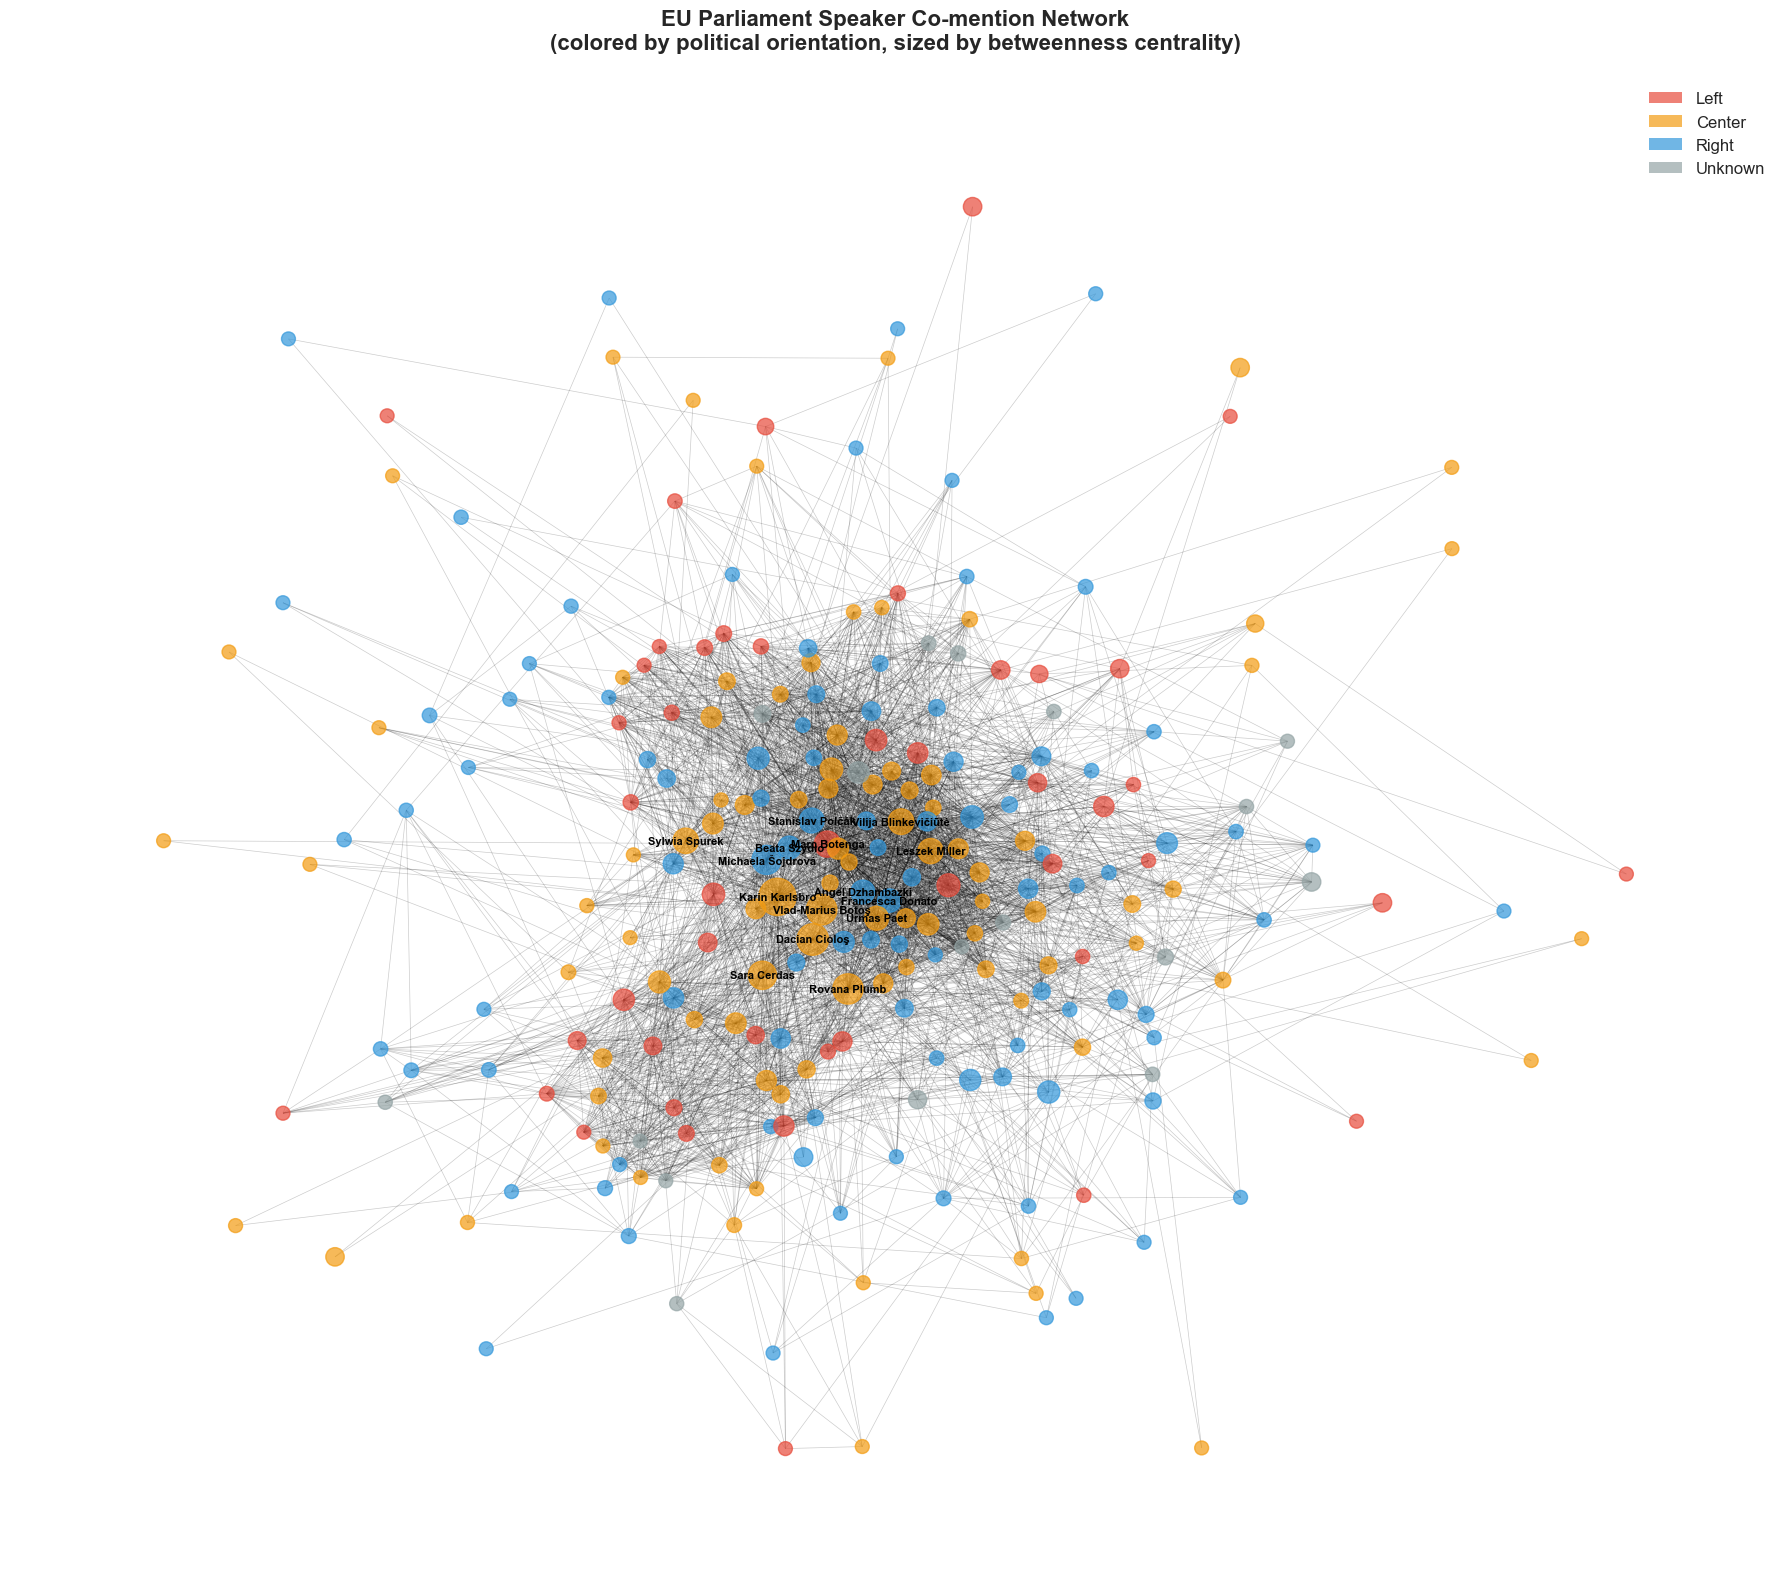

✅ Network visualization with political orientation saved

Creating topic distribution by political orientation...


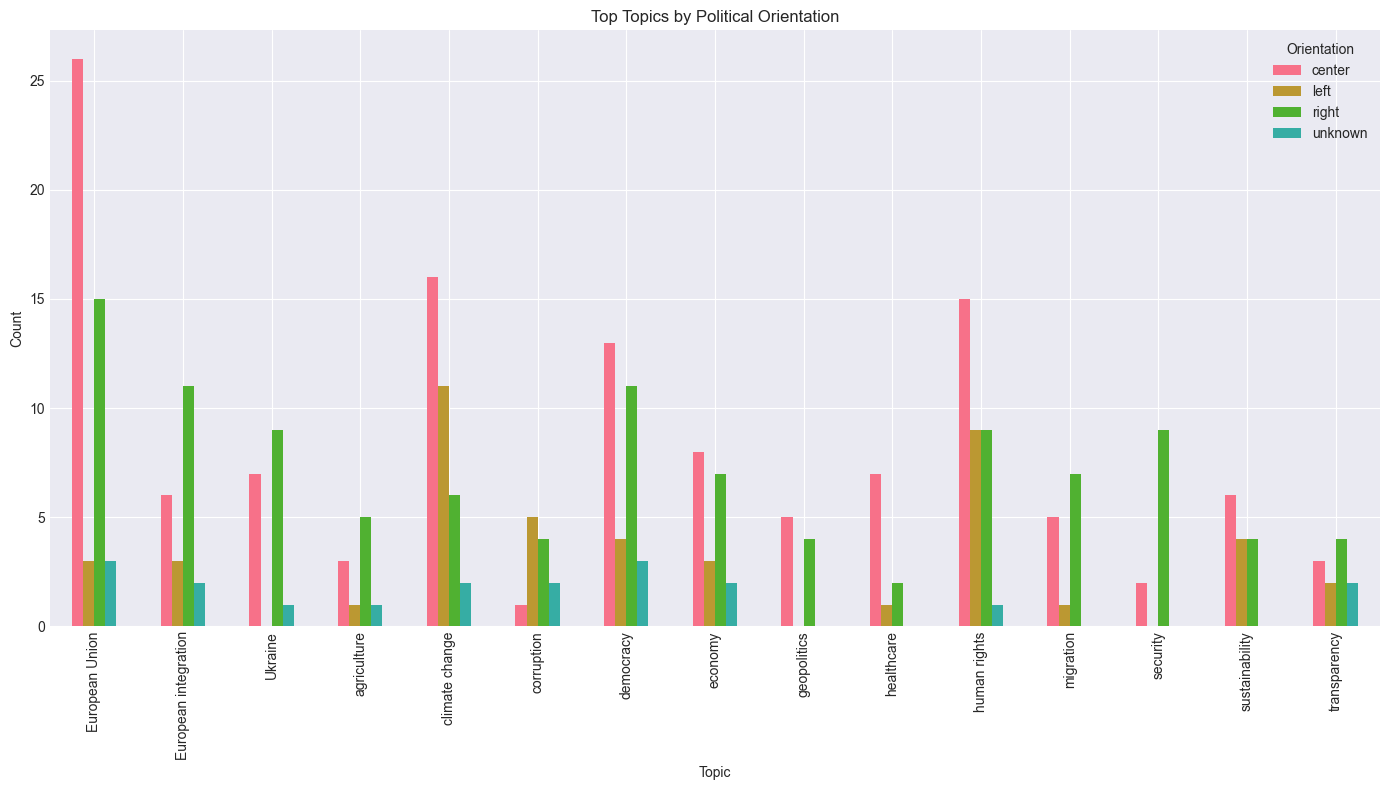

In [55]:
# Create visualizations directory if it doesn't exist
os.makedirs('visualizations', exist_ok=True)

# Create a mapping of speakers to political orientation
speaker_orientation = df_extractions.groupby('speaker_name')['political_orientation'].first().to_dict()

# Define color scheme for political orientations
orientation_colors = {
    'left': '#E74C3C',      # Red
    'center': '#F39C12',    # Orange
    'right': '#3498DB',     # Blue
    'unknown': '#95A5A6'    # Gray
}

# Visualize Speaker-Speaker network with political orientation coloring
fig, ax = plt.subplots(figsize=(18, 16))

# Use only nodes with sufficient connections for clarity
min_degree = 2
nodes_to_plot = [n for n in G_analysis.nodes() if G_analysis.degree(n) >= min_degree]
G_viz = G_analysis.subgraph(nodes_to_plot).copy()

# Layout
pos = nx.spring_layout(G_viz, k=0.5, iterations=50, seed=SEED)

# Node colors by political orientation
node_colors = [orientation_colors.get(speaker_orientation.get(node, 'unknown'), '#95A5A6') 
               for node in G_viz.nodes()]

# Node sizes by betweenness centrality
node_sizes = [betweenness_cent.get(node, 0) * 10000 + 100 for node in G_viz.nodes()]

# Draw network
nx.draw_networkx_nodes(
    G_viz, pos,
    node_color=node_colors,
    node_size=node_sizes,
    alpha=0.7,
    ax=ax
)

nx.draw_networkx_edges(
    G_viz, pos,
    alpha=0.2,
    width=0.5,
    ax=ax
)

# Label top nodes only
top_nodes = centrality_df.head(15)['speaker'].values
labels = {node: node for node in G_viz.nodes() if node in top_nodes}
nx.draw_networkx_labels(
    G_viz, pos,
    labels,
    font_size=8,
    font_weight='bold',
    ax=ax
)

# Add legend for political orientations
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=orientation_colors['left'], label='Left', alpha=0.7),
    Patch(facecolor=orientation_colors['center'], label='Center', alpha=0.7),
    Patch(facecolor=orientation_colors['right'], label='Right', alpha=0.7),
    Patch(facecolor=orientation_colors['unknown'], label='Unknown', alpha=0.7)
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=12)

ax.set_title('EU Parliament Speaker Co-mention Network\n(colored by political orientation, sized by betweenness centrality)', 
             fontsize=16, fontweight='bold', pad=20)
ax.axis('off')
plt.tight_layout()
plt.savefig('visualizations/speaker_network_by_orientation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Network visualization with political orientation saved")

# Additional visualization: Topic distribution by political orientation
print("\nCreating topic distribution by political orientation...")

# Get topics by orientation
topic_orientation_data = []
for _, row in df_extractions.iterrows():
    orientation = row['political_orientation']
    for topic in row['topics']:
        topic_orientation_data.append({
            'topic': topic,
            'orientation': orientation
        })

df_topic_orient = pd.DataFrame(topic_orientation_data)

def build_topic_orientation_df(df_extractions: pd.DataFrame) -> pd.DataFrame:
    df = df_extractions.copy()

    if "topics" not in df.columns:
        raise ValueError("Missing 'topics' column")
    if "political_orientation" not in df.columns and "orientation" not in df.columns:
        raise ValueError("Missing 'political_orientation'/'orientation' column")

    if "orientation" not in df.columns:
        df["orientation"] = df["political_orientation"]

    df = df[["topics", "orientation"]].explode("topics", ignore_index=True)

    def _topic_name(x):
        if isinstance(x, dict):
            return x.get("topic")
        if isinstance(x, str):
            return x
        return None

    df["topic"] = df["topics"].apply(_topic_name)
    df = df.dropna(subset=["topic", "orientation"])
    df["topic"] = df["topic"].astype(str)
    df["orientation"] = df["orientation"].astype(str)

    return df[["topic", "orientation"]]


df_topic_orient = build_topic_orientation_df(df_extractions)


top_topics = df_topic_orient["topic"].value_counts().head(15).index


topic_orient_counts = (
    df_topic_orient[df_topic_orient["topic"].isin(top_topics)]
    .groupby(["topic", "orientation"])
    .size()
    .unstack(fill_value=0)
)

# Plot
fig, ax = plt.subplots(figsize=(14, 8))
topic_orient_counts.sort_index().plot(kind="bar", ax=ax)
ax.set_title("Top Topics by Political Orientation")
ax.set_xlabel("Topic")
ax.set_ylabel("Count")
ax.legend(title="Orientation")
plt.tight_layout()
plt.show()



Creating centrality distribution visualizations...
Computing centralities...


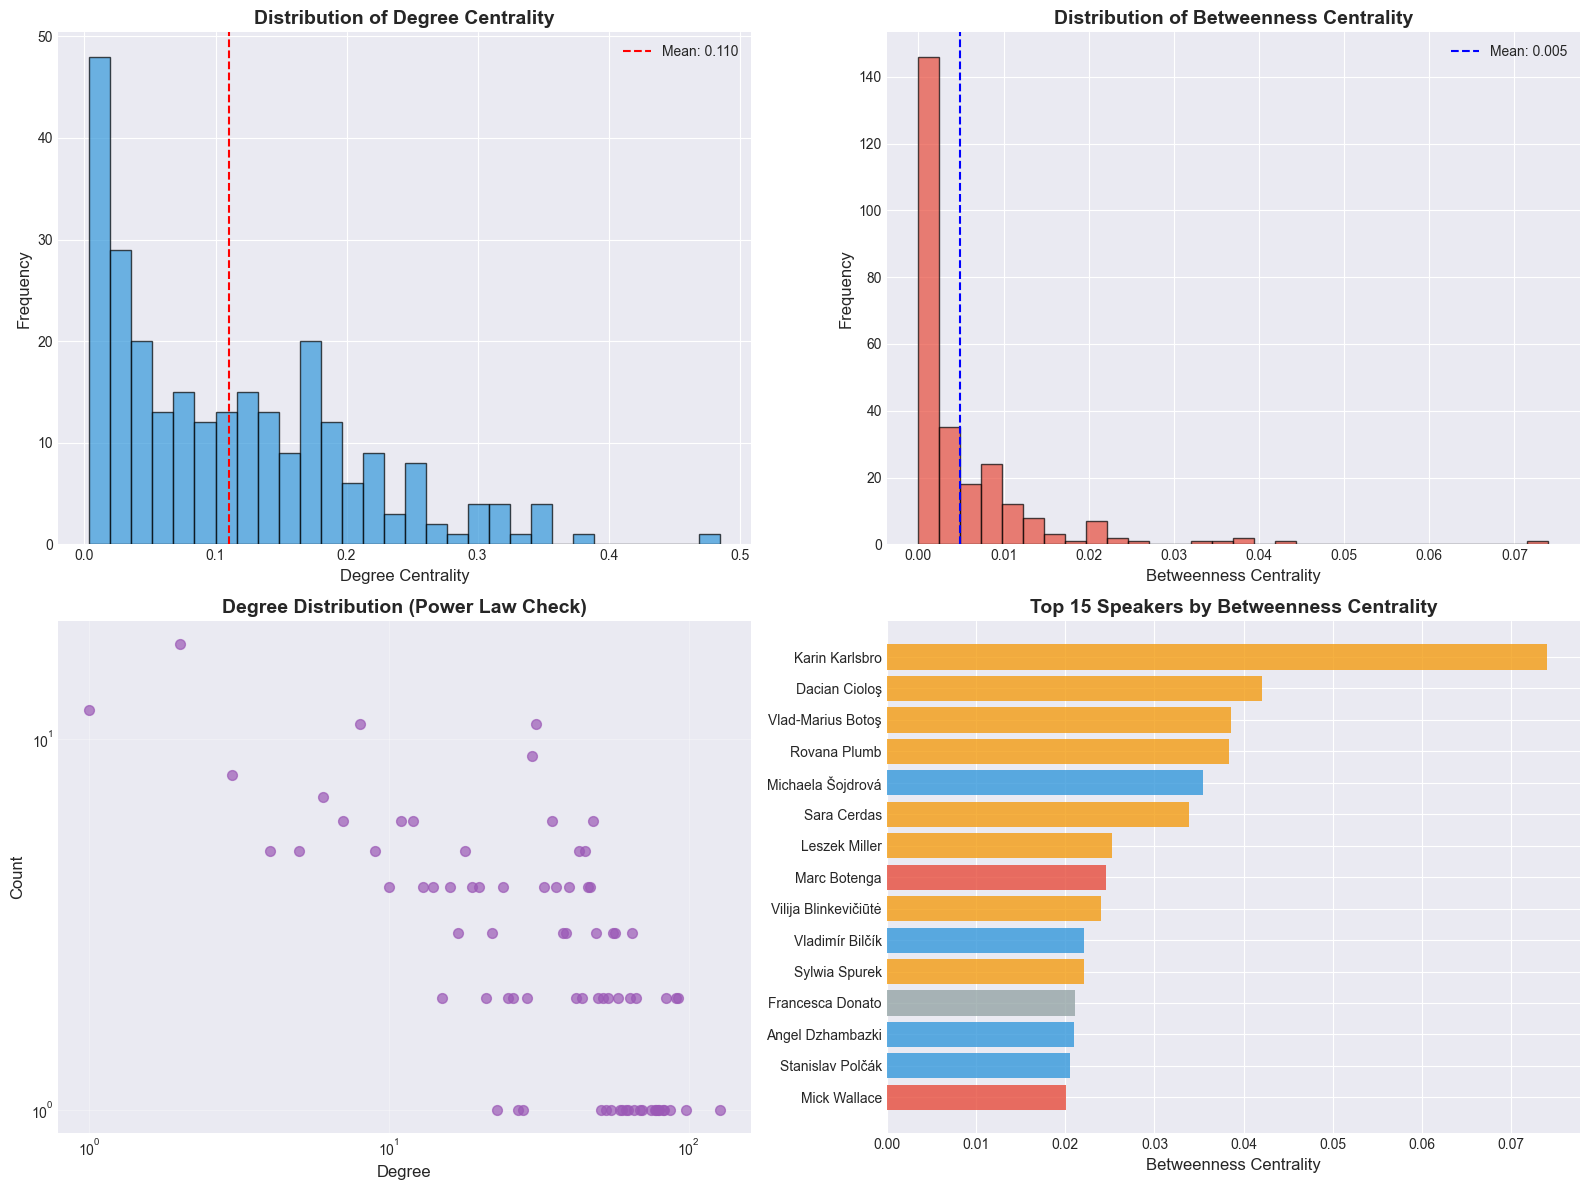

✅ Centrality distributions saved
Creating community structure visualization...


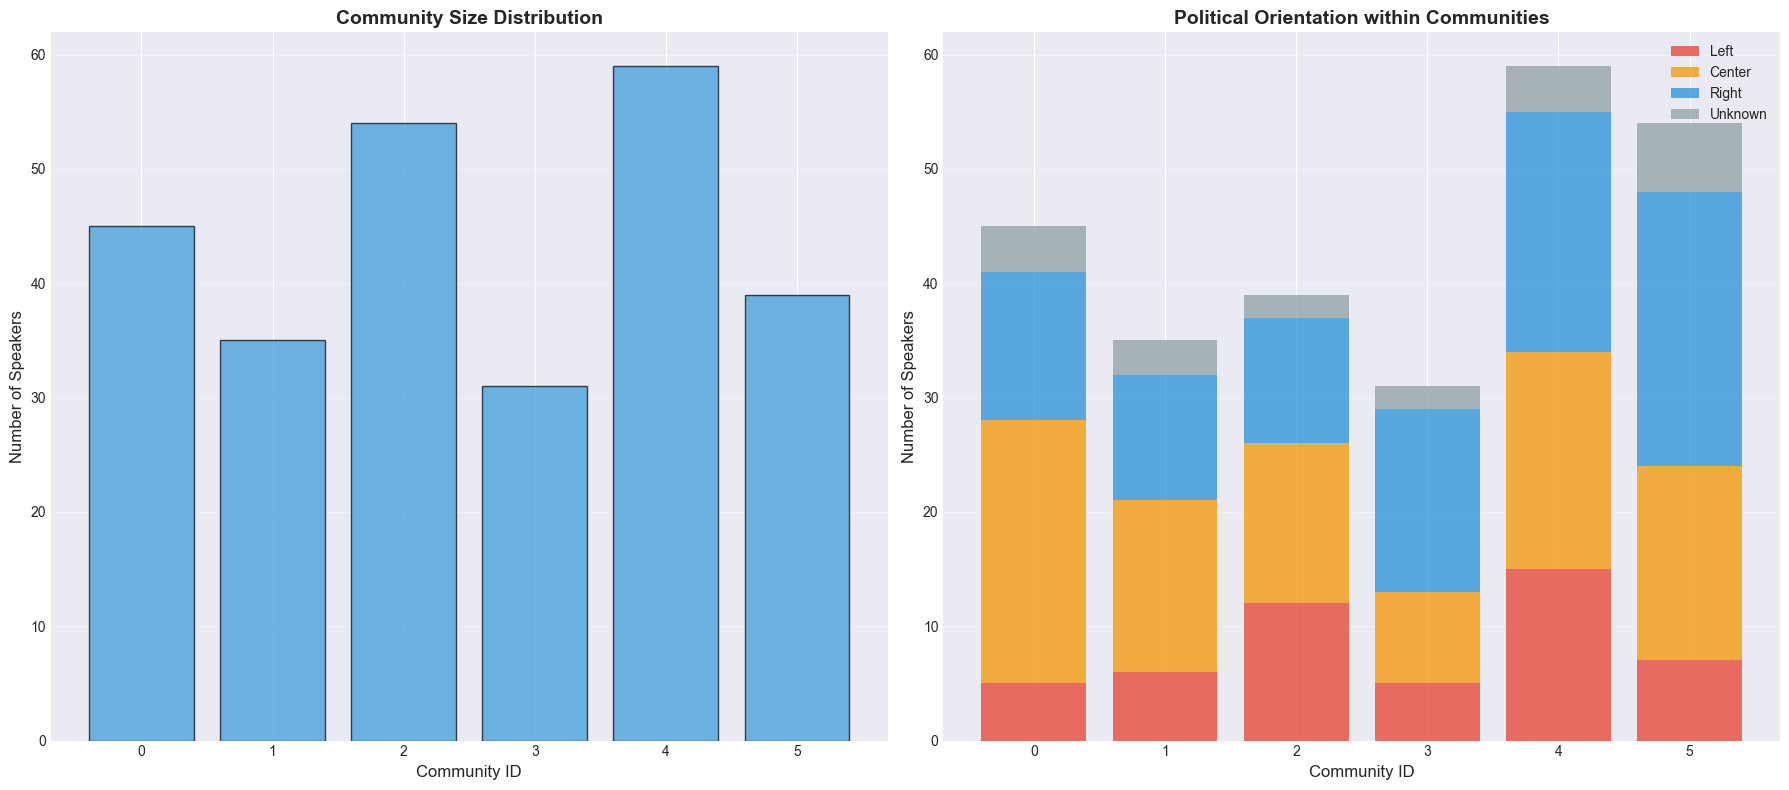

✅ Community structure saved
Creating bipartite network projections...


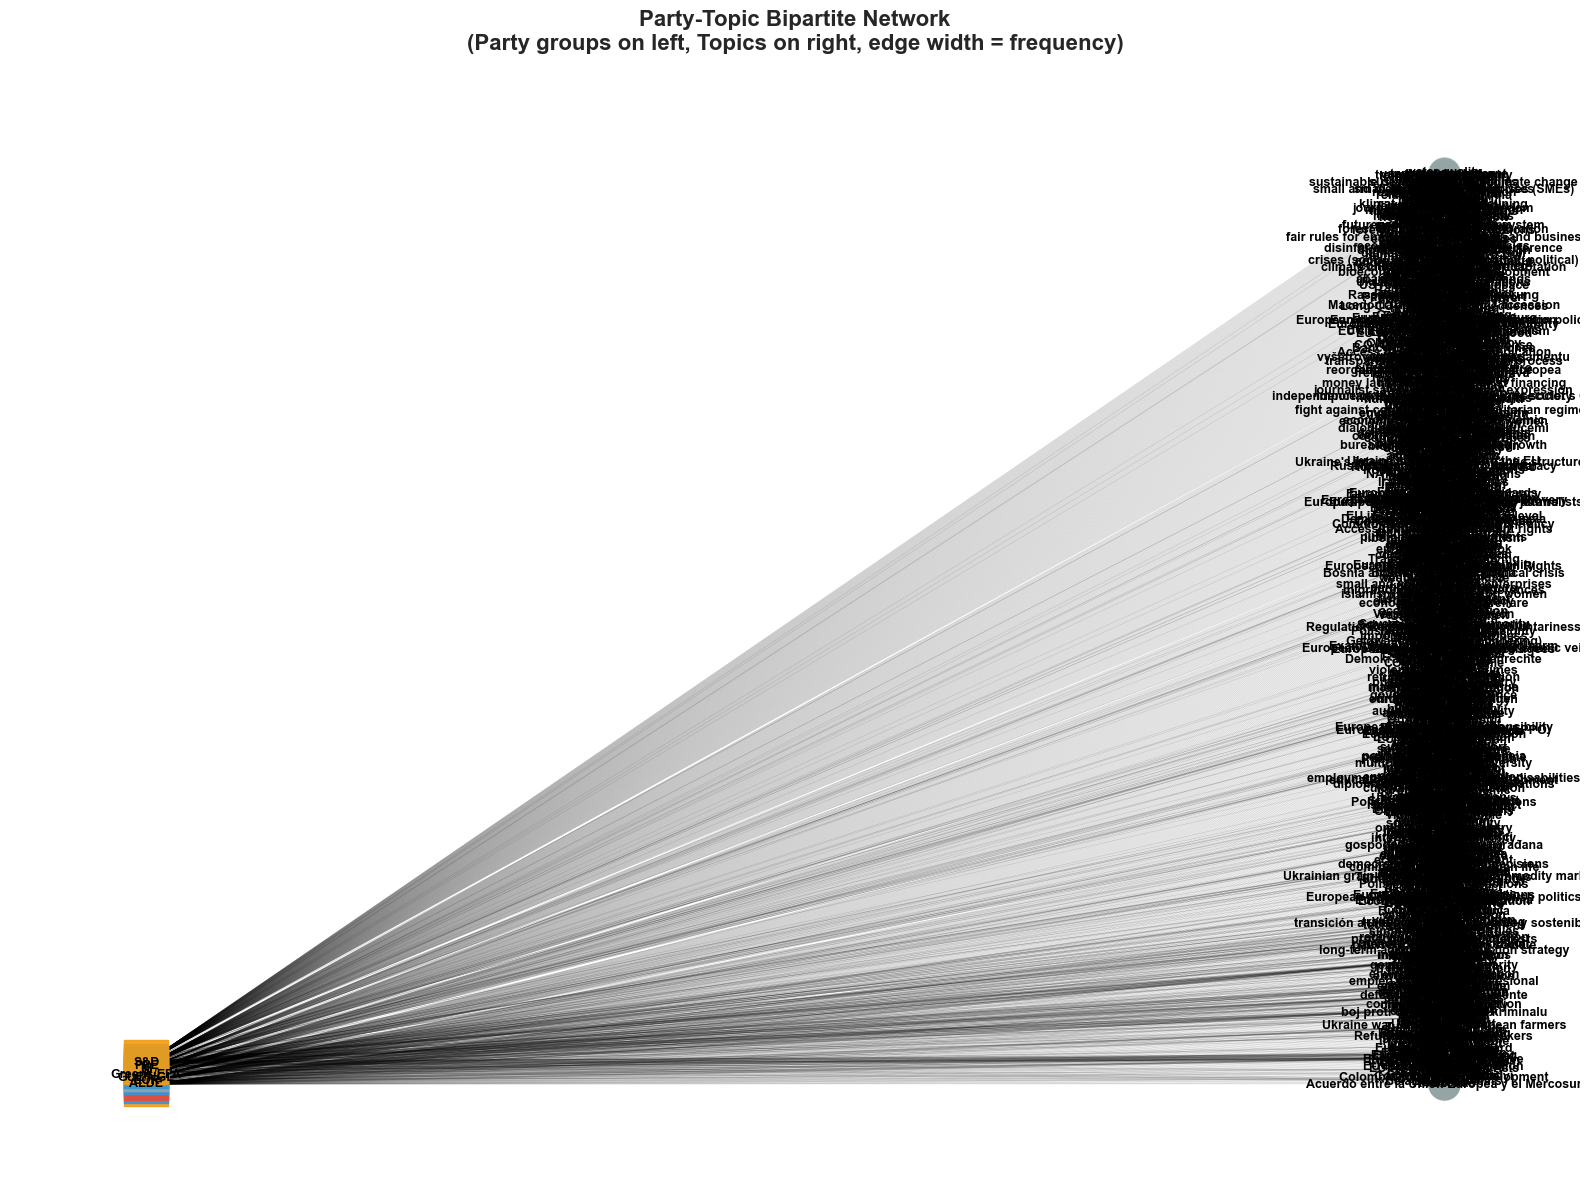

✅ Party-topic bipartite network saved
Creating topic co-occurrence network...


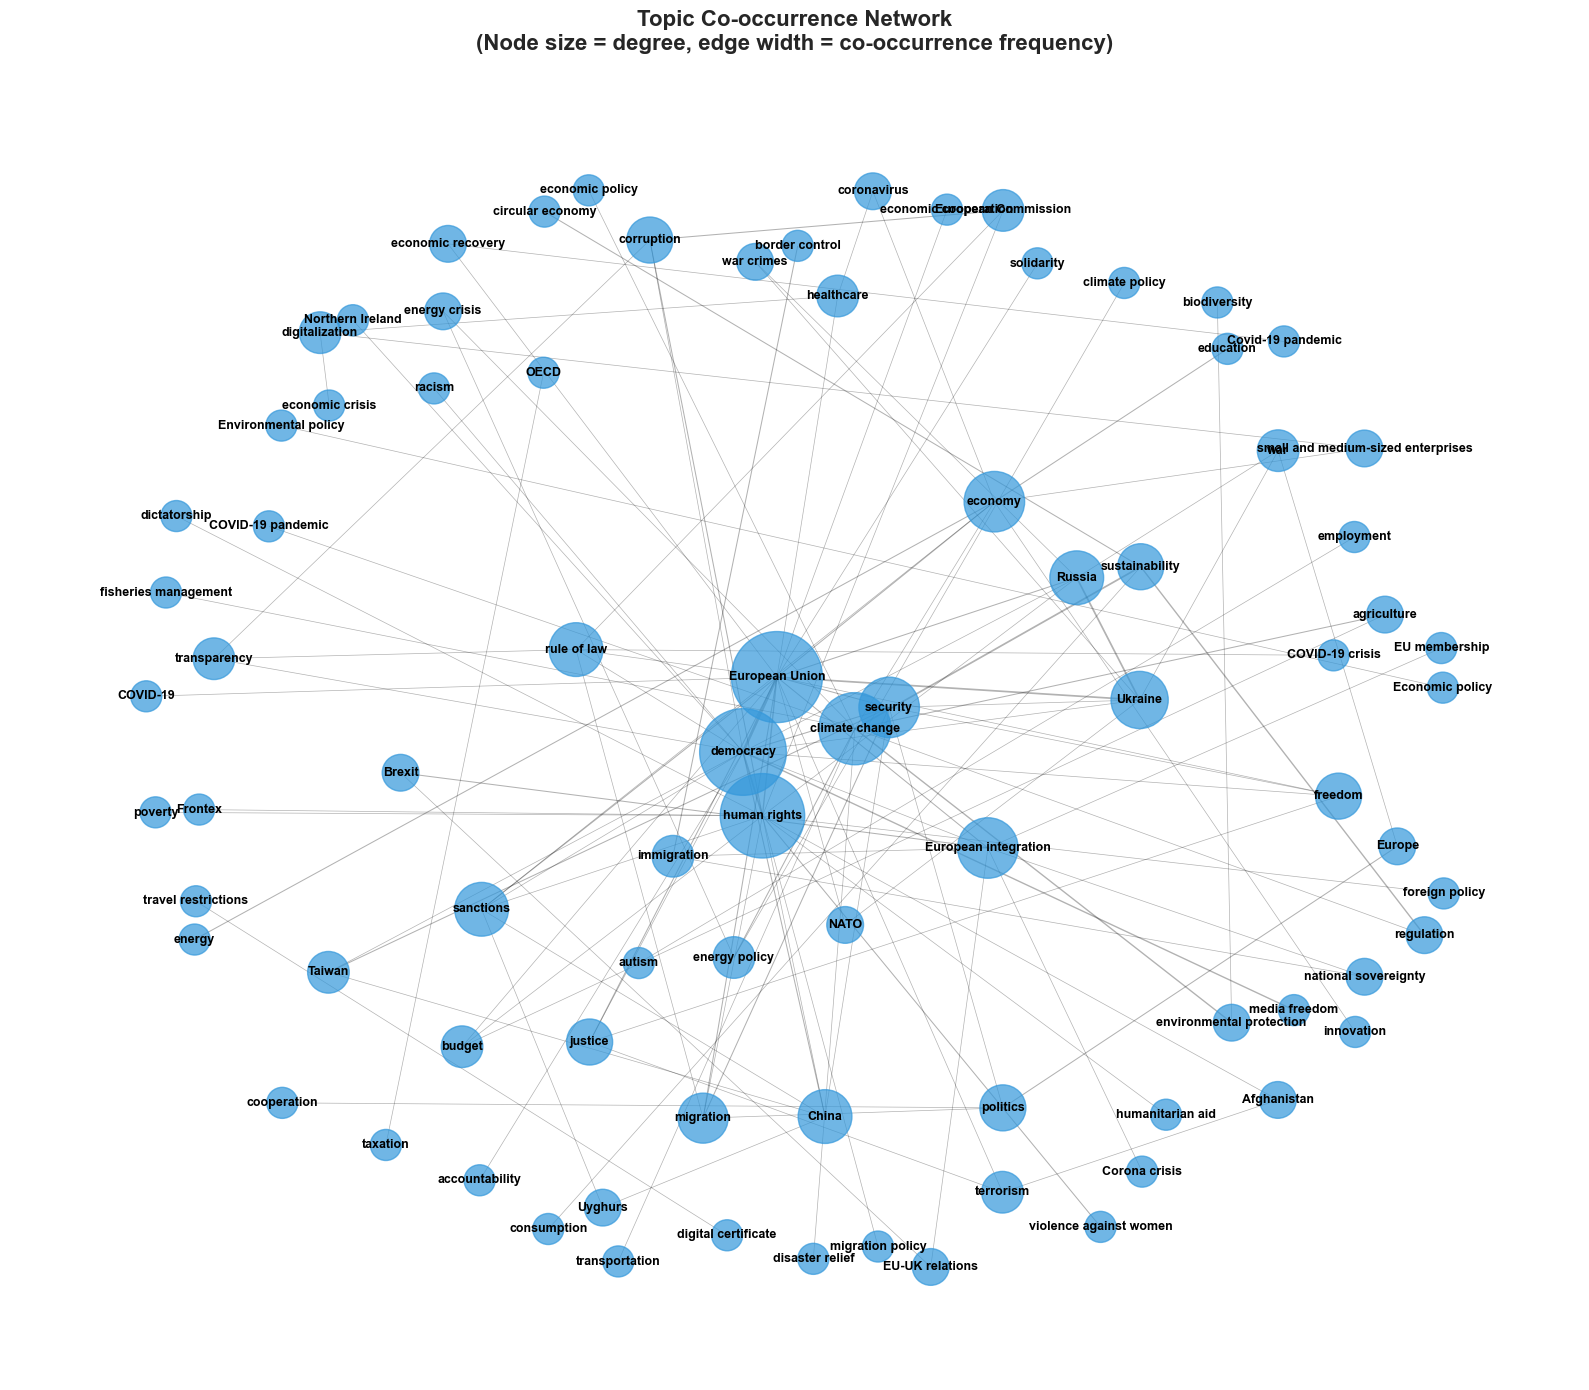

✅ Topic co-occurrence network saved
Creating sentiment distribution visualization...


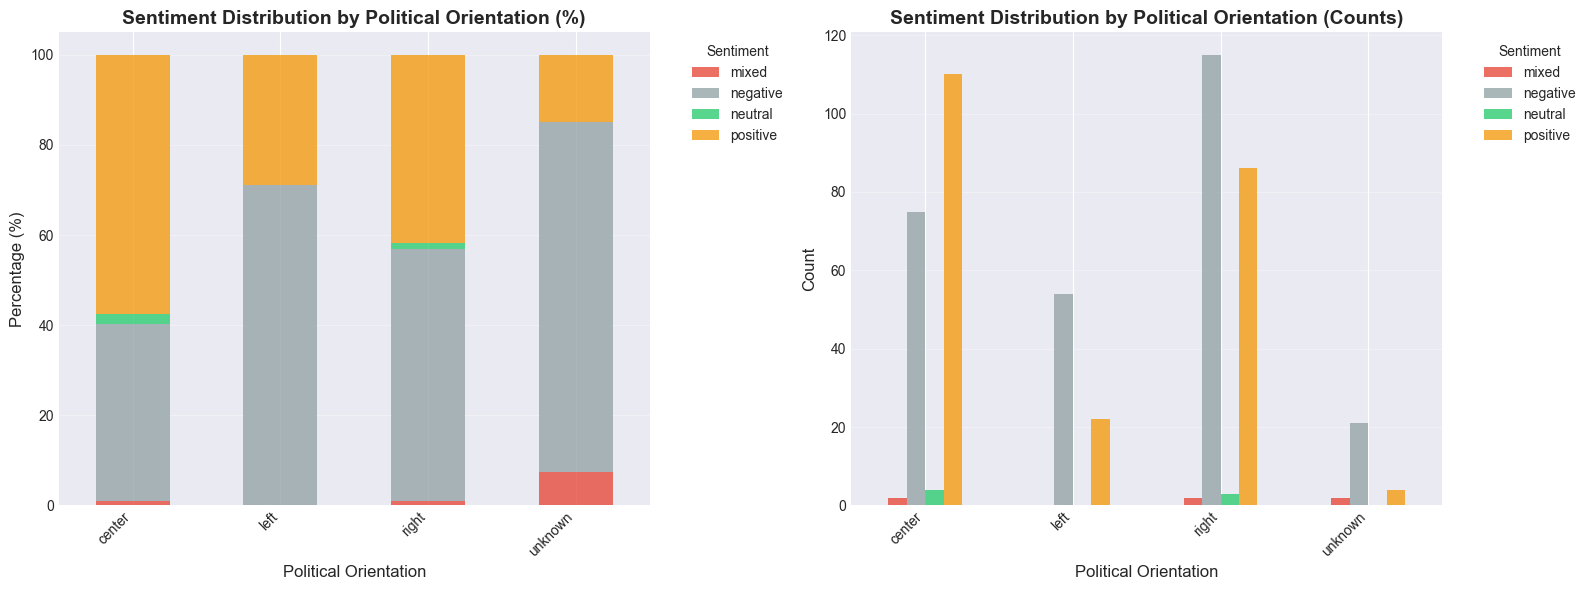

✅ Sentiment distribution saved


In [60]:
 
# Compute communities 
communities = community_louvain.best_partition(G_analysis)

# Step 1: Map speakers to party
speaker_to_party = df_extractions.set_index('speaker_name')['party'].to_dict()


# Step 2: Add 'party' to df_triples
df_triples['party'] = df_triples['subject'].map(speaker_to_party)

# Step 3: Filter and group
party_topic_triples = df_triples[df_triples['relation'] == 'Mentions_Topic'].copy()
party_topic_counts = party_topic_triples.groupby(['party', 'object']).size().reset_index(name='count')

speaker_orientation = df_extractions.set_index('speaker_name')['political_orientation'].to_dict()
# 11.2 Centrality Distribution Visualizations

print("Creating centrality distribution visualizations...")

# Ensure betweenness and degree centralities are computed
print("Computing centralities...")
degree_cent = nx.degree_centrality(G_analysis)
betweenness_cent = nx.betweenness_centrality(G_analysis)

# Combine into DataFrame
centrality_df = pd.DataFrame({
    'speaker': list(degree_cent.keys()),
    'degree': list(degree_cent.values()),
    'betweenness': [betweenness_cent.get(s, 0.0) for s in degree_cent.keys()]
})

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Degree centrality distribution
ax = axes[0, 0]
degree_values = list(degree_cent.values())
ax.hist(degree_values, bins=30, color='#3498DB', alpha=0.7, edgecolor='black')
ax.set_xlabel('Degree Centrality', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Degree Centrality', fontsize=14, fontweight='bold')
ax.axvline(np.mean(degree_values), color='red', linestyle='--', label=f'Mean: {np.mean(degree_values):.3f}')
ax.legend()

# 2. Betweenness centrality distribution
ax = axes[0, 1]
between_values = list(betweenness_cent.values())
ax.hist(between_values, bins=30, color='#E74C3C', alpha=0.7, edgecolor='black')
ax.set_xlabel('Betweenness Centrality', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Betweenness Centrality', fontsize=14, fontweight='bold')
ax.axvline(np.mean(between_values), color='blue', linestyle='--', label=f'Mean: {np.mean(between_values):.3f}')
ax.legend()

# 3. Degree distribution (log-log plot)
ax = axes[1, 0]
degree_sequence = sorted([d for n, d in G_analysis.degree()], reverse=True)
degree_count = {}
for d in degree_sequence:
    degree_count[d] = degree_count.get(d, 0) + 1

degrees = list(degree_count.keys())
counts = list(degree_count.values())
ax.scatter(degrees, counts, alpha=0.7, s=50, color='#9B59B6')
ax.set_xlabel('Degree', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Degree Distribution (Power Law Check)', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# 4. Top 15 speakers by betweenness centrality
ax = axes[1, 1]
top_between = centrality_df.nlargest(15, 'betweenness')
colors = [orientation_colors.get(speaker_orientation.get(speaker, 'unknown'), '#95A5A6') 
          for speaker in top_between['speaker']]
ax.barh(range(len(top_between)), top_between['betweenness'], color=colors, alpha=0.8)
ax.set_yticks(range(len(top_between)))
ax.set_yticklabels(top_between['speaker'], fontsize=10)
ax.set_xlabel('Betweenness Centrality', fontsize=12)
ax.set_title('Top 15 Speakers by Betweenness Centrality', fontsize=14, fontweight='bold')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('visualizations/centrality_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Centrality distributions saved")


print("Creating community structure visualization...")

# Get community sizes
community_sizes = {}
for node, comm in communities.items():
    if comm in community_sizes:
        community_sizes[comm] += 1
    else:
        community_sizes[comm] = 1

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Community size distribution
ax1.bar(range(len(community_sizes)), list(community_sizes.values()), 
        color='#3498DB', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Community ID', fontsize=12)
ax1.set_ylabel('Number of Speakers', fontsize=12)
ax1.set_title('Community Size Distribution', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Political orientation within communities
community_orientation = {}
for node, comm in communities.items():
    orientation = speaker_orientation.get(node, 'unknown')
    if comm not in community_orientation:
        community_orientation[comm] = {'left': 0, 'center': 0, 'right': 0, 'unknown': 0}
    community_orientation[comm][orientation] += 1

# Stacked bar chart
comm_ids = sorted(community_orientation.keys())
left_counts = [community_orientation[c]['left'] for c in comm_ids]
center_counts = [community_orientation[c]['center'] for c in comm_ids]
right_counts = [community_orientation[c]['right'] for c in comm_ids]
unknown_counts = [community_orientation[c]['unknown'] for c in comm_ids]

x = range(len(comm_ids))
ax2.bar(x, left_counts, label='Left', color=orientation_colors['left'], alpha=0.8)
ax2.bar(x, center_counts, bottom=left_counts, label='Center', 
        color=orientation_colors['center'], alpha=0.8)
ax2.bar(x, right_counts, bottom=[l+c for l,c in zip(left_counts, center_counts)], 
        label='Right', color=orientation_colors['right'], alpha=0.8)
ax2.bar(x, unknown_counts, 
        bottom=[l+c+r for l,c,r in zip(left_counts, center_counts, right_counts)], 
        label='Unknown', color=orientation_colors['unknown'], alpha=0.8)

ax2.set_xlabel('Community ID', fontsize=12)
ax2.set_ylabel('Number of Speakers', fontsize=12)
ax2.set_title('Political Orientation within Communities', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('visualizations/community_structure.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Community structure saved")


print("Creating bipartite network projections...")

# Create party-topic bipartite network
party_topic_triples = df_triples[df_triples['relation'] == 'Mentions_Topic'].copy()

# Aggregate by party
party_topic_counts = party_topic_triples.groupby(['party', 'object']).size().reset_index(name='count')

# Create party-topic network
G_party_topic = nx.Graph()
for _, row in party_topic_counts.iterrows():
    G_party_topic.add_edge(row['party'], row['object'], weight=row['count'])

# Visualize
fig, ax = plt.subplots(figsize=(16, 12))

# Separate party and topic nodes
party_nodes = [n for n in G_party_topic.nodes() if n in EU_PARTY_ORIENTATION]
topic_nodes = [n for n in G_party_topic.nodes() if n not in EU_PARTY_ORIENTATION]

# Create bipartite layout
pos = {}
# Parties on the left
for i, party in enumerate(party_nodes):
    pos[party] = (0, i * 2)
# Topics on the right
for i, topic in enumerate(topic_nodes):
    pos[topic] = (3, i * 0.5)

# Draw parties
party_colors = [orientation_colors.get(EU_PARTY_ORIENTATION.get(p, 'unknown'), '#95A5A6') 
                for p in party_nodes]
nx.draw_networkx_nodes(G_party_topic, pos, nodelist=party_nodes, 
                       node_color=party_colors, node_size=1000, 
                       node_shape='s', alpha=0.9, ax=ax)

# Draw topics
nx.draw_networkx_nodes(G_party_topic, pos, nodelist=topic_nodes, 
                       node_color='#95A5A6', node_size=500, 
                       alpha=0.7, ax=ax)

# Draw edges with varying thickness
edges = G_party_topic.edges()
weights = [G_party_topic[u][v]['weight'] for u, v in edges]
max_weight = max(weights)
widths = [3 * (w / max_weight) for w in weights]

nx.draw_networkx_edges(G_party_topic, pos, width=widths, alpha=0.3, ax=ax)

# Labels
nx.draw_networkx_labels(G_party_topic, pos, font_size=9, font_weight='bold', ax=ax)

ax.set_title('Party-Topic Bipartite Network\n(Party groups on left, Topics on right, edge width = frequency)', 
             fontsize=16, fontweight='bold', pad=20)
ax.axis('off')
plt.tight_layout()
plt.savefig('visualizations/party_topic_bipartite.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Party-topic bipartite network saved")

print("Creating topic co-occurrence network...")

from itertools import combinations

topic_cooccurrence = {}

for _, row in df_extractions.iterrows():
    # Extract only topic names
    topics = [t['topic'] for t in row['topics'] if isinstance(t, dict) and 'topic' in t]

    if len(topics) > 1:
        for t1, t2 in combinations(sorted(topics), 2):
            pair = (t1, t2)
            topic_cooccurrence[pair] = topic_cooccurrence.get(pair, 0) + 1


# Create network
G_topics = nx.Graph()
for (t1, t2), count in topic_cooccurrence.items():
    if count >= 2:  # Only include if co-occurred at least twice
        G_topics.add_edge(t1, t2, weight=count)

# Visualize
fig, ax = plt.subplots(figsize=(16, 14))

pos = nx.spring_layout(G_topics, k=1.5, iterations=50, seed=42)

# Node sizes by degree
node_sizes = [G_topics.degree(n) * 200 + 300 for n in G_topics.nodes()]

# Edge widths by weight
edges = G_topics.edges()
weights = [G_topics[u][v]['weight'] for u, v in edges]
max_weight = max(weights) if weights else 1
widths = [2 * (w / max_weight) for w in weights]

# Draw
nx.draw_networkx_nodes(G_topics, pos, node_size=node_sizes, 
                       node_color='#3498DB', alpha=0.7, ax=ax)
nx.draw_networkx_edges(G_topics, pos, width=widths, alpha=0.3, ax=ax)
nx.draw_networkx_labels(G_topics, pos, font_size=9, font_weight='bold', ax=ax)

ax.set_title('Topic Co-occurrence Network\n(Node size = degree, edge width = co-occurrence frequency)', 
             fontsize=16, fontweight='bold', pad=20)
ax.axis('off')
plt.tight_layout()
plt.savefig('visualizations/topic_cooccurrence.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Topic co-occurrence network saved")
# Sentiment Distribution by Political Orientation

print("Creating sentiment distribution visualization...")

# Count sentiment by orientation
sentiment_orientation = df_extractions.groupby(['political_orientation', 'sentiment']).size().unstack(fill_value=0)

# Normalize to percentages
sentiment_orientation_pct = sentiment_orientation.div(sentiment_orientation.sum(axis=1), axis=0) * 100

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Stacked bar chart
sentiment_orientation_pct.plot(kind='bar', stacked=True, ax=ax1, 
                                color=['#E74C3C', '#95A5A6', '#2ECC71', '#F39C12'],
                                alpha=0.8)
ax1.set_xlabel('Political Orientation', fontsize=12)
ax1.set_ylabel('Percentage (%)', fontsize=12)
ax1.set_title('Sentiment Distribution by Political Orientation (%)', fontsize=14, fontweight='bold')
ax1.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.grid(True, alpha=0.3, axis='y')

# Grouped bar chart (absolute counts)
sentiment_orientation.plot(kind='bar', ax=ax2, 
                           color=['#E74C3C', '#95A5A6', '#2ECC71', '#F39C12'],
                           alpha=0.8)
ax2.set_xlabel('Political Orientation', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Sentiment Distribution by Political Orientation (Counts)', fontsize=14, fontweight='bold')
ax2.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('visualizations/sentiment_by_orientation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Sentiment distribution saved")


## 12. Key Findings & Conclusions


Conclusions and open questions

Overall the LLM pipeline did a pretty decent job turning 500 EP speeches into a knowledge graph with around four thousand triples. That was enough to build networks of speakers, topics, time periods and party topic links without me manually coding every speech.

Across the whole period a small core of issues dominates. European Union climate change human rights and democracy are central throughout and from 2022 Ukraine joins that core. So the setup picks up both long running themes and shocks like the war in Ukraine.

The speaker speaker network is fairly dense and suggests that agenda setting is shared across several mainstream party families mainly ALDE S and D and PPE. With a simple left center right coding the set of speeches looks slightly tilted to the right overall but there is still a clear mix of ideological positions.

I do not fully solve some things here
• how much generic topics like European Union distort the structure
• how representative 500 speeches really are
• and to what extent external events and party strategies actually drive the shifts I observe

Main networks and key findings

I mainly work with four networks built from the triples:

Speaker topic bipartite network
This links each speaker to the topics they mention. It is the backbone of the whole analysis since all the other networks are projections of this one.

Speaker speaker co mention network
Two MEPs are connected if they share at least one topic. It is quite dense with a few hundred nodes and several thousand edges. Centrality measures highlight brokers and hubs mostly from ALDE S and D and PPE. Influence therefore looks spread across several groups rather than concentrated in a single camp. Community detection gives clusters of speakers who share issue agendas that broadly line up with party and ideology.

Topic topic co occurrence network
Topics are linked when they are mentioned by the same speaker. A small set of very central topics sits at the core. In 2020 to 2021 that is European Union climate change human rights and democracy. In 2022 to 2023 the same core appears plus Ukraine. This gives a stable normative and institutional core a persistent climate pillar and a clear Ukraine shock in the later period.

Temporal speaker networks
When I split the speaker network into 2020 to 2021 and 2022 to 2023 both remain cohesive and fairly clustered but the later one is a bit sparser and a little more fragmented. Together with the rise of Ukraine this suggests some reallocation of attention and perhaps slightly more issue specialisation.

On top of this I add a basic left center right label based on party families which lets me colour the networks and quickly see how ideological camps overlap or diverge in their issue focus.

Strengths and weaknesses of using an LLM here

For me the LLM is both very useful and something I need to treat with care.

Strengths

• Scale I can turn 500 speeches into structured data topics entities sentiment without hand coding everything
• Flexibility the schema gives me a rich knowledge graph that plugs straight into network analysis
• Reasonable accuracy for big patterns as I wrote in my notes I would say around 85 to 90 percent precision overall entity extraction a bit weaker and sentiment the noisiest dimension but the aggregate patterns still make sense

Weaknesses

• Inconsistent and hard to predict errors the model sometimes gives very generic topics or misses specific ones which can affect centrality and clustering
• Loss of nuance umbrella topics like European Union or democracy hide important distinctions but show up as very central
• Bias and simplifications my left center right coding and English labels are already a simplification and the LLM has its own training biases
• Validation overhead I still need manual checks and basic QA to trust the results which reduces some of the time savings

So in the end I treat the LLM based knowledge graph as a first pass mapping and hypothesis generator. It works well for exploratory questions such as which topics are central and who the main brokers are but I would not rely on it alone for very detailed or high stakes claims about specific parties or individual speeches.

## 13. Export Outputs


In [58]:
# 13. EXPORT OUTPUTS
print("EXPORTING ALL OUTPUTS")

# Create outputs directory if it doesn't exist
os.makedirs('outputs', exist_ok=True)

# 1. Export extracted data
print("\n1. Exporting extracted data...")
df_extractions.to_csv('outputs/extractions.csv', index=False)
df_extractions.to_parquet('outputs/extractions.parquet', index=False)
print(f"   ✅ Saved {len(df_extractions)} extractions to CSV and Parquet")

# 2. Export knowledge graph triples
print("\n2. Exporting knowledge graph triples...")
df_triples.to_csv('outputs/triples.csv', index=False)
df_triples.to_parquet('outputs/triples.parquet', index=False)
print(f"   ✅ Saved {len(df_triples)} triples to CSV and Parquet")

# 3. Export network metrics
print("\n3. Exporting network metrics...")
centrality_df.to_csv('outputs/centrality_metrics.csv', index=False)
print(f"   ✅ Saved centrality metrics for {len(centrality_df)} speakers")

# 4. Export community assignments
print("\n4. Exporting community assignments...")
community_df = pd.DataFrame([
    {'speaker': node, 'community': comm, 'orientation': speaker_orientation.get(node, 'unknown')}
    for node, comm in communities.items()
])
community_df.to_csv('outputs/communities.csv', index=False)
print(f"   ✅ Saved community assignments for {len(community_df)} speakers")

# 5. Export summary statistics
print("\n5. Exporting summary statistics...")
summary_stats = {
    'dataset': {
        'total_speeches': len(df_sample),
        'total_extractions': len(df_extractions),
        'total_triples': len(df_triples),
        'unique_speakers': df_extractions['speaker_name'].nunique(),
        'unique_parties': df_extractions['party'].nunique(),
        'unique_topics': len(set(
            t['topic'] for topics in df_extractions['topics']
            if isinstance(topics, list)
            for t in topics if isinstance(t, dict) and 'topic' in t
        )),
        'unique_entities': len(set(
            e['name'] for entities in df_extractions['entities']
            if isinstance(entities, list)
            for e in entities if isinstance(e, dict) and 'name' in e
        )),
    },
    'network': {
        'num_nodes': G_analysis.number_of_nodes(),
        'num_edges': G_analysis.number_of_edges(),
        'density': nx.density(G_analysis),
        'num_communities': len(set(communities.values())),
        'avg_degree': sum(dict(G_analysis.degree()).values()) / G_analysis.number_of_nodes(),
        'avg_betweenness': sum(betweenness_cent.values()) / len(betweenness_cent),
    },
    'political_orientation': {
        'left': int((df_extractions['political_orientation'] == 'left').sum()),
        'center': int((df_extractions['political_orientation'] == 'center').sum()),
        'right': int((df_extractions['political_orientation'] == 'right').sum()),
        'unknown': int((df_extractions['political_orientation'] == 'unknown').sum()),
    }
}


with open('outputs/summary_statistics.json', 'w') as f:
    json.dump(summary_stats, f, indent=2)
print(f"   ✅ Saved summary statistics")

# 6. List all visualization files
print("\n6. Visualization files created:")
viz_files = [
    'visualizations/speaker_network_by_orientation.png',
    'visualizations/topics_by_orientation.png',
    'visualizations/centrality_distributions.png',
    'visualizations/community_structure.png',
    'visualizations/party_topic_bipartite.png',
    'visualizations/topic_cooccurrence.png',
    'visualizations/sentiment_by_orientation.png',
]
for vf in viz_files:
    if os.path.exists(vf):
        print(f"   ✅ {vf}")
    else:
        print(f"   ⚠️  {vf} (not created)")

print("EXPORT SUMMARY")
print(f"""
Data Files:
  - outputs/extractions.csv (and .parquet)
  - outputs/triples.csv (and .parquet)
  - outputs/centrality_metrics.csv
  - outputs/communities.csv
  - outputs/summary_statistics.json
  - outputs/quality_assessment.json
  - outputs/findings_and_conclusions.txt

Visualizations:
  - visualizations/speaker_network_by_orientation.png
  - visualizations/topics_by_orientation.png
  - visualizations/centrality_distributions.png
  - visualizations/community_structure.png
  - visualizations/party_topic_bipartite.png
  - visualizations/topic_cooccurrence.png
  - visualizations/sentiment_by_orientation.png

Total: {len(df_extractions)} speeches, {len(df_triples)} triples, {len(viz_files)} visualizations
""")

print("✅ ALL OUTPUTS EXPORTED SUCCESSFULLY")


EXPORTING ALL OUTPUTS

1. Exporting extracted data...
   ✅ Saved 500 extractions to CSV and Parquet

2. Exporting knowledge graph triples...
   ✅ Saved 3966 triples to CSV and Parquet

3. Exporting network metrics...
   ✅ Saved centrality metrics for 263 speakers

4. Exporting community assignments...
   ✅ Saved community assignments for 263 speakers

5. Exporting summary statistics...
   ✅ Saved summary statistics

6. Visualization files created:
   ✅ visualizations/speaker_network_by_orientation.png
   ⚠️  visualizations/topics_by_orientation.png (not created)
   ✅ visualizations/centrality_distributions.png
   ✅ visualizations/community_structure.png
   ✅ visualizations/party_topic_bipartite.png
   ✅ visualizations/topic_cooccurrence.png
   ✅ visualizations/sentiment_by_orientation.png
EXPORT SUMMARY

Data Files:
  - outputs/extractions.csv (and .parquet)
  - outputs/triples.csv (and .parquet)
  - outputs/centrality_metrics.csv
  - outputs/communities.csv
  - outputs/summary_statist